# **Project: Solar Cycle**

**Course:** Optimisation and High performance Computing (OHPC-HS25-AD23)  
**Team Members:** Cieplinski Nicole, Plos Penelope, Yeji Huber
**Date:** 16.01.2026

In [ ]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path
import glob


## Project Overview

In this project, we apply **Simulated Annealing (SA)** to optimize the parameters of a given objective function derived from the provided dataset.  
The main goal is to **minimize the Mean Squared Error (MSE)** by tuning the model parameters efficiently under computational constraints.

The project follows the workflow taught in the Optimization and High Performance Computing (OHPC) module and emphasizes:
- correct implementation of Simulated Annealing,
- systematic hyperparameter tuning,
- reproducibility,
- and interpretation of optimization results.

## Problem Description

The task consists of optimizing a model by minimizing an objective function based on the provided dataset.  
Due to the **non-convex and potentially multi-modal** nature of the optimization landscape, classical gradient-based methods are not suitable.

Instead, **Simulated Annealing** is chosen because:
- it allows probabilistic uphill moves,
- it avoids getting trapped in local minima,
- and it scales well to high-dimensional or noisy optimization problems.

The quality of a solution is evaluated using the **Mean Squared Error (MSE)**.

## Simulated Annealing (SA) function

### SA function for hyper-parameter tuning


This function runs one complete Simulated Annealing optimization for a given set of hyperparameters.  
Starting from an initial parameter vector, it iteratively updates the parameters in order to minimize the objective function.

At each iteration, a new candidate solution is generated by adding a random perturbation drawn from a multivariate normal distribution with zero mean and a diagonal covariance matrix controlled by the parameter `sigma`. The objective function is evaluated for both the current and proposed solutions, and the difference in loss is used to decide whether the proposal is accepted.

If the proposed solution improves the loss, it is accepted immediately. Otherwise, it may still be accepted with a probability given by the Metropolis criterion, which depends on the current temperature. The temperature is updated at every iteration using a linear cooling schedule, gradually reducing the likelihood of accepting worse solutions.

To reduce storage requirements, the function supports thinning, meaning that only every `thinning`-th parameter vector is saved. The function returns the stored parameter vectors, which are later used for analysis and visualization.

In [ ]:
def sa_tune(x0, T0, sigma, f, n_iter=2e5, thinning=10):

    # Copy initial parameter vector
    x = x0.copy()

    # Set initial temperature
    T = T0

    # Number of parameters to optimize
    n_params = x0.shape[0]

    # Define proposal distribution: zero mean Gaussian
    means = np.zeros(n_params)

    # Diagonal covariance matrix with step size sigma
    cov_matrix = np.diag(np.full(n_params, sigma))

    # Compute number of stored states after thinning
    # (store every `thinning`-th iteration)
    size_out = int((n_iter + thinning - 1) // thinning)

    # Allocate array to store sampled parameter vectors
    v = np.zeros((size_out, n_params))

    # Store initial state
    v[0, :] = x

    # Iteration counters
    iter_counter = 0
    iter_counter_thin = 0

    # Print initial loss
    print("Initial loss:", f(x))

    # Main simulated annealing loop
    while iter_counter < n_iter:
        iter_counter += 1

        # Store current state
        x_old = x

        # Propose new candidate using Gaussian perturbation
        x_proposal = x_old + np.random.multivariate_normal(means, cov_matrix)

        # Compute change in objective function
        DeltaE = f(x_proposal) - f(x_old)

        # Metropolis accept/reject step
        if np.exp(-np.clip(DeltaE / T, -100, 100)) >= np.random.rand():
            x = x_proposal
        else:
            x = x_old

        # Update temperature using linear cooling schedule
        T = T0 * (1 - iter_counter / n_iter)

        # Print progress information
        if iter_counter % 1 == 0:
            print("Iteration", iter_counter, "- Temperature:", T, "Loss", f(x))

        # Store thinned samples
        if iter_counter % thinning == 0:
            v[iter_counter_thin, :] = x
            iter_counter_thin += 1

    # Return stored parameter samples
    return v
    

### SA function for final optimization

This function performs the final Simulated Annealing optimization using a fixed set of hyperparameters.  
It is intended to generate optimized parameter samples after the tuning phase has identified suitable values for the initial temperature and proposal scale.

The algorithm starts from an initial parameter vector and iteratively proposes new candidate solutions using a multivariate normal perturbation controlled by the parameter `sigma`. At each iteration, the objective function is evaluated and the difference in loss is used to decide whether the proposed solution is accepted.

The acceptance decision follows the Metropolis criterion and depends explicitly on the current temperature, making worse solutions less likely to be accepted as the temperature decreases. A linear cooling schedule is applied throughout the run.

During optimization, constraints are applied to the `T0` parameters to ensure physically meaningful solutions: each `T0` value is kept within a small range around its initial estimate, and the sequence is repaired to remain strictly increasing.

An initial burn-in phase is used to discard early iterations where the algorithm is still exploring the parameter space. Only parameter vectors generated after the burn-in period are stored and returned for further analysis.

In [ ]:
def sa_optimize(x0, T0, sigma, f, n_iter=2.5e5, burn_in=2e5):

    # Copy initial parameter vector
    x = x0.copy()

    # Set initial temperature
    T = T0

    # Number of parameters to optimize
    n_params = x0.shape[0]

    # Define proposal distribution: zero mean Gaussian
    means = np.zeros(n_params)

    # Diagonal covariance matrix with step size sigma
    cov_matrix = np.diag(np.full(n_params, sigma))

    # Allocate array for samples after burn-in
    size_out = int(n_iter - burn_in)
    v = np.zeros((size_out, n_params))

    # Iteration counter
    iter_counter = 0

    # Print initial loss
    print("Initial loss:", f(x))

    # Main simulated annealing loop
    while iter_counter < n_iter:
        iter_counter += 1

        # Store current state
        x_old = x

        # Propose new candidate using Gaussian perturbation
        x_proposal = x_old + np.random.multivariate_normal(means, cov_matrix)

        # Compute change in objective function
        DeltaE = f(x_proposal) - f(x_old)

        # Metropolis accept/reject step
        if np.exp(-np.clip(DeltaE / T, -100, 100)) >= np.random.rand():
            x = x_proposal
        else:
            x = x_old

        # Update temperature using linear cooling schedule
        T = T0 * (1 - iter_counter / n_iter)

        # Print progress every 10 iterations
        if iter_counter % 10 == 0:
            print("Iteration", iter_counter, "- Temperature:", T, "- Loss:", f(x))

        # Store samples only after burn-in phase
        if iter_counter > burn_in:
            v[iter_counter - int(burn_in) - 1, :] = x

    # Return samples collected after burn-in
    return v

## Load data

In this next step, we load the CSV data provided for our team and visualize it to get a first impression of the dataset.

In [ ]:
# load the dataset
data = np.loadtxt('data_Team9.csv', delimiter=',', skiprows=1) 

In [ ]:
# show shape of the dataset
data.shape

(39220, 2)

In [ ]:
# show first 5 rows of
data.head()

array([[1878.15199877,   13.65877439],
       [1878.15477652,   13.22461169],
       [1878.15755428,   14.05492822],
       ...,
       [1987.08717135,    8.53057405],
       [1987.08994911,    3.49094437],
       [1987.09272686,    0.        ]])

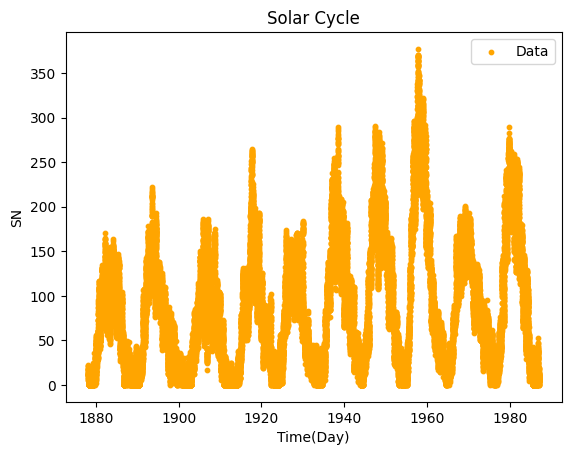

In [ ]:
#Plot the data
plt.figure()
plt.scatter(data[:,0], data[:,1], color="Orange", s=10, label= "Data")
plt.xlabel("Time(Day)")
plt.ylabel("SN")
plt.title("Solar Cycle")
plt.legend()
plt.show()

In [ ]:
# extract time points and data points
time_points = data[:, 0]
n_data = time_points.shape[0]
data_points = data[:, 1]

print(time_points)
print(n_data)
print(data_points)

[1878.15199877 1878.15477652 1878.15755428 ... 1987.08717135 1987.08994911
 1987.09272686]
39220
[13.65877439 13.22461169 14.05492822 ...  8.53057405  3.49094437
  0.        ]


## Initial Conditions and Phase Setup

This section defines the initial parameter values used for the optimization.  
The parameter vector `x0` contains the initial guesses for all model parameters, arranged phase by phase. For each phase, the parameters are stored consecutively in the vector, following a fixed structure used throughout the project.

The initial values are chosen according to the specifications given in the project description and relevant literature. These values provide a consistent and reasonable starting point for the Simulated Annealing algorithm.

The model is defined in terms of multiple phases (or cycles), each characterized by three parameters: a start time `T0`, a rise time `Ts`, and a decay time `Td`. During model evaluation, the time intervals corresponding to each phase are constructed dynamically from the `T0` parameters inside the model function itself.

### Parameter structure

- Phase 1: `T0_1`, `Ts_1`, `Td_1`  
- Phase 2: `T0_2`, `Ts_2`, `Td_2`  
- …  
- Phase 10: `T0_10`, `Ts_10`, `Td_10`

In [ ]:
# Parameter vector structure:
# x0 = [T0_1, ..., T0_10, Ts_1, ..., Ts_10, Td_1, ..., Td_10]
# Total: 30 parameters (10 cycle start times, 10 rise times, 10 decay times)

# Initial T0 values for cycles 1–10
# Taken from literature (Hathaway, 2015)
T0_INITIAL = np.array([
    1878.916666666666667,  # T0_1
    1890.166666666666667,  # T0_2
    1902.000000000000000,  # T0_3
    1913.500000000000000,  # T0_4
    1923.583333333333333,  # T0_5
    1933.666666666666667,  # T0_6
    1944.083333333333333,  # T0_7
    1954.250000000000000,  # T0_8
    1964.750000000000000,  # T0_9
    1976.166666666666667   # T0_10
], dtype=float)

# Construct full initial parameter vector
# Ts and Td are initialized with constant values for all cycles
x0 = np.concatenate([
    T0_INITIAL,            # T0 parameters (cycle start times)
    np.array([0.3] * 10),  # Ts parameters (rise times)
    np.array([5.0] * 10)   # Td parameters (decay times)
], dtype=float)

# Sanity check: print shape and parameter grouping
print(f"\nx0 shape: {x0.shape}")
print(f"x0 structure: [T0 ({x0[:10]}), Ts ({x0[10:20]}), Td ({x0[20:30]})]")


x0 shape : (30,)
x0 structure: [T0 ([1878.91666667 1890.16666667 1902.         1913.5        1923.58333333
 1933.66666667 1944.08333333 1954.25       1964.75       1976.16666667]), Ts ([0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3]), Td ([5. 5. 5. 5. 5. 5. 5. 5. 5. 5.])]


## Model Definition and Loss Function

This section defines the model used to describe the data across multiple phases and the corresponding loss function used for optimization.

The model function takes a time variable `t` and a parameter vector `x` as input. The parameter vector is split into phase-specific parameters, where each phase is described by three parameters: a start time `T0`, a rise time `Ts`, and a decay time `Td`. The model is evaluated piecewise over time intervals defined by successive `T0` values, with each interval corresponding to one phase. Boolean masks are used to apply the correct model expression to the appropriate time range.

To ensure consistent behavior, the time input is converted to an array, and the model output is assembled phase by phase. A scalar value is returned when the input consists of a single time point.

The loss function is defined as the Mean Squared Error (MSE) between the observed data points and the model predictions. This function serves as the objective function for the Simulated Annealing algorithm.

Finally, the initial model output is visualized together with the observed data. This plot provides a baseline reference before optimization and allows visual inspection of how well the initial parameter values fit the data. The initial MSE value is also computed and reported.

### Model

In [ ]:
# Model for multiple phases with 30 parameters
# Parameter structure: [T0_1, ..., T0_10, Ts_1, ..., Ts_10, Td_1, ..., Td_10]

def model(t, x):
    # Number of solar cycles (phases)
    n_cycles = 10

    # Split parameter vector into phase-wise components
    T0 = x[:n_cycles]                 # Cycle start times (T0_1 to T0_10)
    Ts = x[n_cycles:2*n_cycles]       # Rise-time parameters (Ts_1 to Ts_10)
    Td = x[2*n_cycles:]               # Decay-time parameters (Td_1 to Td_10)

    # Use T0 values directly to define phase boundaries
    T0ARRAY = T0

    # Define time intervals for each phase:
    # (T0_1, T0_2), (T0_2, T0_3), ..., (T0_9, T0_10), (T0_10, ∞)
    intervals = [
        (T0ARRAY[ix], T0ARRAY[ix + 1]) for ix in range(n_cycles - 1)
    ] + [(T0ARRAY[n_cycles - 1], np.inf)]

    # Ensure time input is treated as an array
    t = np.atleast_1d(t)

    # Initialize model output
    model_output = np.zeros_like(t, dtype=float)

    # Evaluate model phase by phase
    for ix, (a, b) in enumerate(intervals):
        # Select time points belonging to the current phase
        mask = (a <= t) & (t < b)

        # Apply phase-specific model formula
        model_output[mask] = (
            ((t[mask] - T0ARRAY[ix]) / Ts[ix]) ** 2
            * np.exp(-((t[mask] - T0ARRAY[ix]) / Td[ix]) ** 2)
        )

    # Return scalar if input was scalar, otherwise return array
    if model_output.size == 1:
        return model_output.item()
    else:
        return model_output

### Loss function

In [ ]:
# Mean Squared Error (MSE) loss function
# Measures the average squared difference between data and model prediction
def mse(x):
    return np.mean(np.square(data_points - model(time_points, x)))

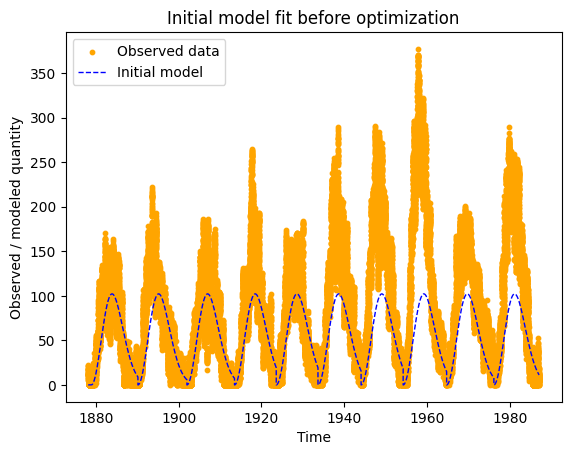

In [ ]:
# Visualization of initial model fit before optimization
plt.figure()
plt.scatter(time_points, data_points, color='orange', s=10, label="Observed data")
plt.plot(time_points, model(time_points, x0), color='blue', linestyle='--', linewidth=1, label="Initial model")
plt.xlabel("Time")
plt.ylabel("Observed / modeled quantity")
plt.title("Initial model fit before optimization")
plt.legend()
plt.show(block=False)

The figure above shows the observed data together with the model output evaluated using the initial parameter vector `x0`, before any optimization is performed.

While the initial model captures the overall cyclic structure of the data, there are clear discrepancies in both amplitude and timing across several phases. This behavior is expected, as the initial parameter values are only rough estimates taken from literature and have not yet been optimized for the given dataset.

This visualization serves as a baseline reference and highlights the need for parameter optimization using Simulated Annealing.

## Hyperparameter Tuning

Before running the full hyperparameter sweep, we performed a small set of short Simulated Annealing trials to identify a reasonable range for the key hyperparameters: `sigma` (proposal scale) and `T0` (initial temperature). The goal is practical: avoid settings where updates are so large that the loss becomes unstable, or so small that the algorithm barely moves and the loss does not improve.

For each short trial, we record the tested `(T0, sigma)` pair and the **final MSE**. We also inspect the **MSE curve over iterations** as a sanity check:
- A good setting typically shows an overall decreasing trend and then stabilizes.
- If the curve is extremely noisy or diverges, `sigma` is likely too large (jumps are too aggressive).
- If the curve is almost flat, `sigma` is likely too small (insufficient exploration).
- Changing `T0` mainly affects early exploration (higher `T0` tends to accept more moves initially).

Based on these quick trials, we define an 8×8 grid of candidate values for `(T0, sigma)` and run a systematic sweep on the cluster. Each combination produces a final MSE (and an optional convergence plot), which we use to select a suitable hyperparameter pair for the final calibration run.

In [ ]:
# List to store results from quick SA tuning trials
trial_log = []

# Store hyperparameters and final MSE for one trial
def log_trial(T0, sigma, final_x):
    trial_log.append({
        "T0": float(T0),              # Initial temperature used
        "sigma": float(sigma),        # Step size used
        "final_mse": float(mse(final_x))  # Final loss of the trial
    })

Initial loss: 3228.00669565451
Iteration 1  - Temperature: 0.9999 Loss 3228.00669565451
Iteration 2  - Temperature: 0.9998 Loss 3228.00669565451
Iteration 3  - Temperature: 0.9997 Loss 3228.00669565451
Iteration 4  - Temperature: 0.9996 Loss 3228.00669565451
Iteration 5  - Temperature: 0.9995 Loss 3228.00669565451
Iteration 6  - Temperature: 0.9994 Loss 3228.00669565451
Iteration 7  - Temperature: 0.9993 Loss 3228.00669565451
Iteration 8  - Temperature: 0.9992 Loss 3228.00669565451
Iteration 9  - Temperature: 0.9991 Loss 3228.00669565451
Iteration 10  - Temperature: 0.999 Loss 3228.00669565451
Iteration 11  - Temperature: 0.9989 Loss 3228.00669565451
Iteration 12  - Temperature: 0.9988 Loss 3228.00669565451
Iteration 13  - Temperature: 0.9987 Loss 3228.00669565451
Iteration 14  - Temperature: 0.9986 Loss 3228.00669565451
Iteration 15  - Temperature: 0.9985 Loss 3228.00669565451
Iteration 16  - Temperature: 0.9984 Loss 3228.00669565451
Iteration 17  - Temperature: 0.9983 Loss 3228.00669

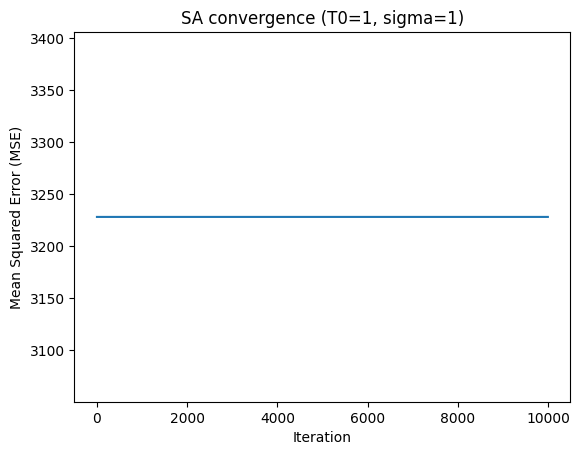

In [ ]:
# Set hyperparameters for a single test run
T0 = 1
sigma = 1

# Run a short SA trial to evaluate this hyperparameter combination
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning=1)

# Plot convergence of the loss function over iterations
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

# Compute final MSE of the last SA state
mse(outSA[-1])

# Log trial results (T0, sigma, final MSE)
log_trial(T0, sigma, outSA[-1])

### SA convergence (T0 = 1, σ = 1)

- **Observed behavior:**  
  The MSE curve remains completely flat across all iterations.

- **Interpretation:**  
  This indicates that the proposed parameter updates are almost never accepted. With `σ = 1`, the proposal steps are far too large for this problem, causing nearly all proposals to lead to significantly worse solutions that are rejected by the Metropolis criterion. As a result, the algorithm remains stuck at the initial parameter vector.

- **Conclusion:**  
  This hyperparameter setting is **not suitable**. The step size `σ` is too large and prevents effective exploration of the parameter space. Such configurations are discarded in subsequent tuning.

Initial loss: 3228.00669565451
Iteration 1  - Temperature: 0.9999 Loss 3228.00669565451
Iteration 2  - Temperature: 0.9998 Loss 3228.00669565451
Iteration 3  - Temperature: 0.9997 Loss 3228.00669565451
Iteration 4  - Temperature: 0.9996 Loss 3228.00669565451
Iteration 5  - Temperature: 0.9995 Loss 3228.00669565451
Iteration 6  - Temperature: 0.9994 Loss 3228.00669565451
Iteration 7  - Temperature: 0.9993 Loss 3228.00669565451
Iteration 8  - Temperature: 0.9992 Loss 3228.00669565451
Iteration 9  - Temperature: 0.9991 Loss 3228.00669565451
Iteration 10  - Temperature: 0.999 Loss 3228.00669565451
Iteration 11  - Temperature: 0.9989 Loss 3228.00669565451
Iteration 12  - Temperature: 0.9988 Loss 3228.00669565451
Iteration 13  - Temperature: 0.9987 Loss 3228.00669565451
Iteration 14  - Temperature: 0.9986 Loss 3228.00669565451
Iteration 15  - Temperature: 0.9985 Loss 3228.00669565451
Iteration 16  - Temperature: 0.9984 Loss 3228.00669565451
Iteration 17  - Temperature: 0.9983 Loss 3228.00669

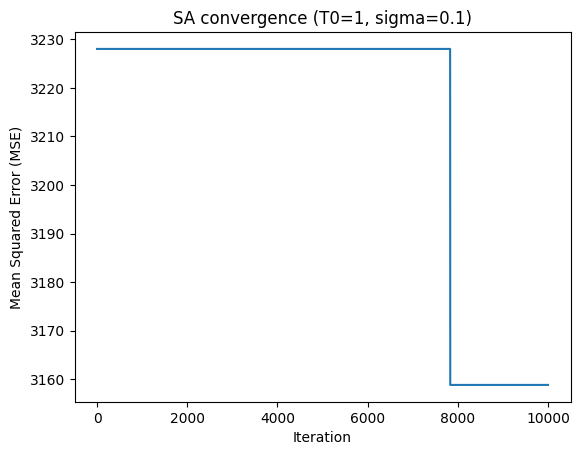

In [ ]:
# Set hyperparameters for another SA test run
T0 = 1
sigma = 0.1

# Run a short SA trial with smaller step size
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning=1)

# Plot convergence of the loss over iterations
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

# Compute final MSE of the trial
mse(outSA[-1])

# Log trial results for later comparison
log_trial(T0, sigma, outSA[-1])

### SA convergence (T0 = 1, σ = 0.1)

- **Observed behavior:**  
  The MSE stays almost constant for most of the run and then shows a **single late drop** (around ~7,800 iterations), after which it **stabilizes again** at a slightly lower level.

- **Interpretation:**  
  Compared to the previous case (`σ = 1`), reducing the step size to `σ = 0.1` allows the algorithm to **occasionally accept a meaningful move**, but only **rarely**. The long flat region suggests the chain spends most iterations near the initial solution (little effective exploration), and the late drop likely corresponds to the first time it finds and accepts a noticeably better parameter set.

- **Conclusion:**  
  This setting is **still too large / inefficient** for reliable progress: improvement happens, but only after many iterations and without smooth convergence. We therefore continue decreasing `σ` to obtain **more frequent accepted moves** and a **steadier decrease** in MSE.

Initial loss: 3228.00669565451
Iteration 1  - Temperature: 0.9999 Loss 3228.00669565451
Iteration 2  - Temperature: 0.9998 Loss 3228.00669565451
Iteration 3  - Temperature: 0.9997 Loss 3228.00669565451
Iteration 4  - Temperature: 0.9996 Loss 3228.00669565451
Iteration 5  - Temperature: 0.9995 Loss 3228.00669565451
Iteration 6  - Temperature: 0.9994 Loss 3228.00669565451
Iteration 7  - Temperature: 0.9993 Loss 3228.00669565451
Iteration 8  - Temperature: 0.9992 Loss 3228.00669565451
Iteration 9  - Temperature: 0.9991 Loss 2371.4142691040233
Iteration 10  - Temperature: 0.999 Loss 2371.4142691040233
Iteration 11  - Temperature: 0.9989 Loss 2371.4142691040233
Iteration 12  - Temperature: 0.9988 Loss 2371.4142691040233
Iteration 13  - Temperature: 0.9987 Loss 2371.4142691040233
Iteration 14  - Temperature: 0.9986 Loss 2371.4142691040233
Iteration 15  - Temperature: 0.9985 Loss 2371.4142691040233
Iteration 16  - Temperature: 0.9984 Loss 2371.4142691040233
Iteration 17  - Temperature: 0.9983

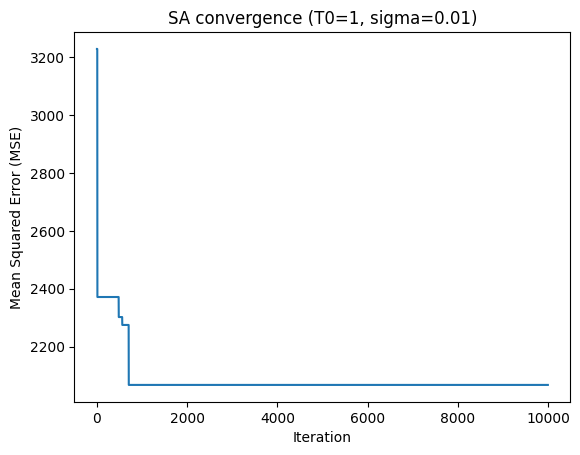

In [ ]:
# Set hyperparameters for another SA test run
T0 = 1
sigma = 0.01

# Run a short SA trial with reduced step size
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning=1)

# Plot convergence of the loss over iterations
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

# Compute final MSE of the trial
mse(outSA[-1])

# Log trial results for later comparison
log_trial(T0, sigma, outSA[-1])

### SA convergence (T0 = 1, σ = 0.01)

- **Observed behavior:**  
  In contrast to the previous two cases, the MSE now shows a clear decreasing trend with several stepwise drops, eventually stabilizing at a significantly lower value.

- **Interpretation:**  
  Compared to the runs with `σ = 1` and `σ = 0.1`, reducing the step size to `σ = 0.01` allows the algorithm to make meaningful parameter updates. The step-like decreases are characteristic of Simulated Annealing, where improvements are accepted intermittently as better configurations are discovered.

- **Conclusion:**  
  This setting represents a **substantial improvement** over larger step sizes. The proposal scale is still too large for this problem. The algorithm fails to make progress, and this hyperparameter combination is therefore discarded.

Initial loss: 3228.00669565451
Iteration 1  - Temperature: 0.9999 Loss 3228.00669565451
Iteration 2  - Temperature: 0.9998 Loss 3128.1376650917314
Iteration 3  - Temperature: 0.9997 Loss 3037.9216642632805
Iteration 4  - Temperature: 0.9996 Loss 3037.9216642632805
Iteration 5  - Temperature: 0.9995 Loss 3037.9216642632805
Iteration 6  - Temperature: 0.9994 Loss 2740.4819314620354
Iteration 7  - Temperature: 0.9993 Loss 2740.4819314620354
Iteration 8  - Temperature: 0.9992 Loss 2710.779381776456
Iteration 9  - Temperature: 0.9991 Loss 2710.779381776456
Iteration 10  - Temperature: 0.999 Loss 2710.779381776456
Iteration 11  - Temperature: 0.9989 Loss 2480.4377018706014
Iteration 12  - Temperature: 0.9988 Loss 2480.4377018706014
Iteration 13  - Temperature: 0.9987 Loss 2405.8733412302113
Iteration 14  - Temperature: 0.9986 Loss 2405.8733412302113
Iteration 15  - Temperature: 0.9985 Loss 2405.8733412302113
Iteration 16  - Temperature: 0.9984 Loss 2309.501814639596
Iteration 17  - Temperatu

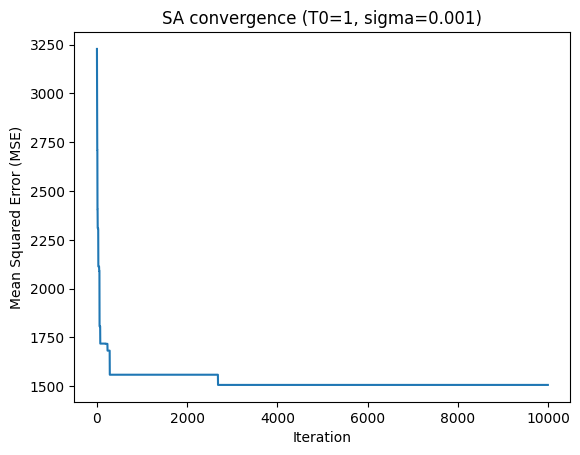

In [ ]:
# Set hyperparameters for another SA test run
T0 = 1
sigma = 0.001

# Run a short SA trial with a smaller step size
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning=1)

# Plot convergence of the loss over iterations
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

# Compute final MSE of the trial
mse(outSA[-1])

# Log trial results for later comparison
log_trial(T0, sigma, outSA[-1])

### SA convergence (T0 = 1, σ = 0.001)

- **Observed behavior:**  
  The MSE decreases rapidly during the early iterations and then continues to decline more gradually, eventually stabilizing at a lower value than in the previous case.

- **Interpretation:**  
  Compared to the run with `σ = 0.01`, reducing the step size further to `σ = 0.001` leads to more stable and consistent improvements. The rapid initial drop indicates efficient early exploration, while the slower later decrease reflects fine-grained local refinement of the parameters.

- **Conclusion:**  
  This hyperparameter setting performs better than larger `σ` values and yields a lower final MSE but the proposal scale is still too large for this problem. The algorithm fails to make progress, and this hyperparameter combination is therefore discarded.

Initial loss: 3228.00669565451
Iteration 1  - Temperature: 0.9999 Loss 3160.6887741417017
Iteration 2  - Temperature: 0.9998 Loss 3146.1063132385743
Iteration 3  - Temperature: 0.9997 Loss 3146.1063132385743
Iteration 4  - Temperature: 0.9996 Loss 3129.723965898286
Iteration 5  - Temperature: 0.9995 Loss 3068.309662230939
Iteration 6  - Temperature: 0.9994 Loss 3059.371588547476
Iteration 7  - Temperature: 0.9993 Loss 2929.0949713824198
Iteration 8  - Temperature: 0.9992 Loss 2788.724256297309
Iteration 9  - Temperature: 0.9991 Loss 2788.724256297309
Iteration 10  - Temperature: 0.999 Loss 2659.892988448159
Iteration 11  - Temperature: 0.9989 Loss 2659.892988448159
Iteration 12  - Temperature: 0.9988 Loss 2659.892988448159
Iteration 13  - Temperature: 0.9987 Loss 2659.892988448159
Iteration 14  - Temperature: 0.9986 Loss 2516.5961214670892
Iteration 15  - Temperature: 0.9985 Loss 2455.1810906504375
Iteration 16  - Temperature: 0.9984 Loss 2336.1019419992917
Iteration 17  - Temperature:

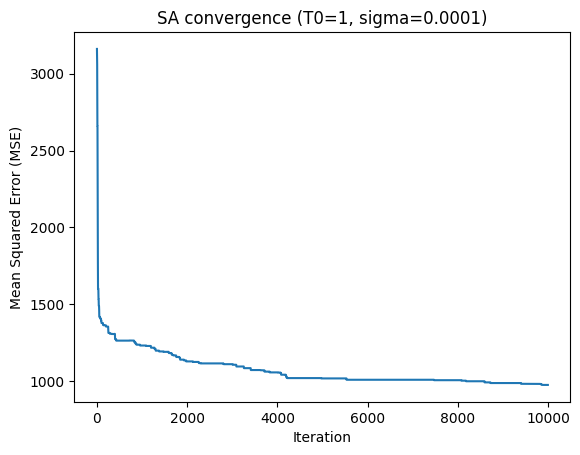

In [ ]:
# Set hyperparameters for another SA test run
T0 = 1
sigma = 0.0001

# Run a short SA trial with a very small step size
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning=1)

# Plot convergence of the loss over iterations
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

# Compute final MSE of the trial
mse(outSA[-1])

# Log trial results for later comparison
log_trial(T0, sigma, outSA[-1])

### SA convergence (T0 = 1, σ = 0.0001)

- **Observed behavior:**  
  The MSE drops sharply at the beginning and then continues to decrease steadily over the entire run, reaching a lower final value than in the previous configurations.

- **Interpretation:**  
  Compared to `σ = 0.001`, using a smaller step size of `σ = 0.0001` results in smoother and more gradual convergence. The algorithm explores the parameter space more conservatively, allowing consistent acceptance of small improvements without destabilizing jumps.

- **Conclusion:**  
  This configuration yields one of the lowest final MSE values observed so far and shows stable convergence behavior. The step size appears well tuned, making this setting a very strong candidate for further tuning and final calibration.

Initial loss: 3228.00669565451
Iteration 1  - Temperature: 0.9999 Loss 3221.6249718354825
Iteration 2  - Temperature: 0.9998 Loss 3221.6249718354825
Iteration 3  - Temperature: 0.9997 Loss 3221.6249718354825
Iteration 4  - Temperature: 0.9996 Loss 3201.7772217313873
Iteration 5  - Temperature: 0.9995 Loss 3201.7772217313873
Iteration 6  - Temperature: 0.9994 Loss 3162.06124017633
Iteration 7  - Temperature: 0.9993 Loss 3155.2022071478664
Iteration 8  - Temperature: 0.9992 Loss 3137.961920891865
Iteration 9  - Temperature: 0.9991 Loss 3111.4796147635802
Iteration 10  - Temperature: 0.999 Loss 3025.10024656898
Iteration 11  - Temperature: 0.9989 Loss 3023.1075865054204
Iteration 12  - Temperature: 0.9988 Loss 3008.343831205803
Iteration 13  - Temperature: 0.9987 Loss 2978.130455590835
Iteration 14  - Temperature: 0.9986 Loss 2978.130455590835
Iteration 15  - Temperature: 0.9985 Loss 2945.405322912479
Iteration 16  - Temperature: 0.9984 Loss 2939.1508247599554
Iteration 17  - Temperature:

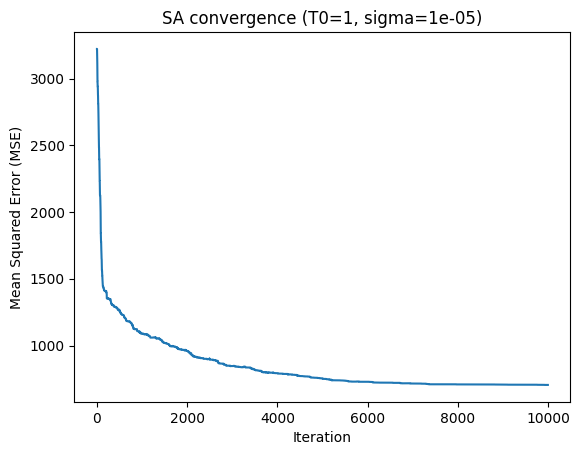

np.float64(704.9506629431734)

In [ ]:
# Set hyperparameters for another SA test run
T0 = 1
sigma = 0.00001

# Run a short SA trial with a very small step size
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning=1)

# Plot convergence of the loss over iterations
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

# Log trial results for later comparison
log_trial(T0, sigma, outSA[-1])

# Compute final MSE of the trial
mse(outSA[-1])

### SA convergence (T0 = 1, σ = 1×10⁻⁵)

- **Observed behavior:**  
  The MSE decreases rapidly at the beginning and then continues to decline smoothly, eventually reaching the lowest final value among all tested step sizes for `T0 = 1`.

- **Interpretation:**  
  Compared to the previous setting with `σ = 0.0001`, further reducing the step size to `σ = 1×10⁻⁵` results in even more stable and fine-grained convergence. The algorithm consistently accepts small improvements, allowing precise local refinement of the parameters without introducing instability.

- **Conclusion:**  
  This configuration yields one of the lowest final MSE values observed so far and shows stable convergence behavior. The step size appears well tuned, making this setting a very strong candidate for further tuning and final calibration.

In [ ]:
# Convert logged tuning trials into a DataFrame
df_trials = pd.DataFrame(trial_log)

# Sort trials by final MSE (lower is better)
df_trials = df_trials.sort_values("final_mse").reset_index(drop=True)

# Display the top 10 best-performing hyperparameter combinations
df_trials.head(10)

T0    sigma    final_mse
0  1.0  0.00001   704.950663
1  1.0  0.00010   975.544214
2  1.0  0.00100  1506.365082
3  1.0  0.01000  2067.866775
4  1.0  0.10000  3158.854048
5  1.0  1.00000  3228.006696

-> we can test sigma from 1e-4 to 1e-11

### Test to assess the influence of the initial temperature T0
In this set of experiments, the step size `sigma` is kept fixed while the initial temperature `T0` is varied.  
The goal is to assess how the choice of `T0` influences the early exploration behavior and convergence of the Simulated Annealing algorithm.

By comparing the convergence curves for different values of `T0` under the same proposal scale, we can isolate the effect of the initial temperature. Higher values of `T0` generally allow more exploratory moves early in the optimization, while lower values lead to more conservative behavior from the start.

Based on these results, we identify suitable `T0` values to include in the full hyperparameter tuning sweep.

Initial loss: 3228.00669565451
Iteration 1  - Temperature: 0.09999000000000001 Loss 3228.00669565451
Iteration 2  - Temperature: 0.09998000000000001 Loss 3183.9007701019136
Iteration 3  - Temperature: 0.09997 Loss 3175.1324556986783
Iteration 4  - Temperature: 0.09996000000000001 Loss 3134.921887950675
Iteration 5  - Temperature: 0.09995000000000001 Loss 3134.921887950675
Iteration 6  - Temperature: 0.09994 Loss 3134.921887950675
Iteration 7  - Temperature: 0.09993 Loss 3118.290931048021
Iteration 8  - Temperature: 0.09992000000000001 Loss 3118.290931048021
Iteration 9  - Temperature: 0.09991 Loss 3118.290931048021
Iteration 10  - Temperature: 0.0999 Loss 3118.290931048021
Iteration 11  - Temperature: 0.09989 Loss 3118.290931048021
Iteration 12  - Temperature: 0.09988000000000001 Loss 3078.7416684245936
Iteration 13  - Temperature: 0.09987000000000001 Loss 3078.7416684245936
Iteration 14  - Temperature: 0.09986 Loss 3078.7416684245936
Iteration 15  - Temperature: 0.09985000000000001 Lo

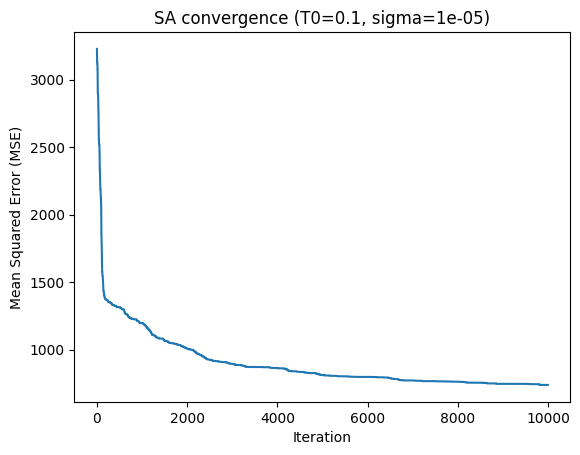

In [ ]:
# Set hyperparameters to test the effect of a smaller initial temperature
T0 = 0.1
sigma = 0.00001

# Run a short SA trial with reduced initial temperature
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning=1)

# Plot convergence of the loss over iterations
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

# Compute final MSE of the trial
mse(outSA[-1])

# Log trial results for later comparison
log_trial(T0, sigma, outSA[-1])

### SA convergence (T0 = 0.1, σ = 1×10⁻⁵)

- **Observed behavior:**  
  The MSE drops sharply during the first iterations and then continues to decrease smoothly, eventually stabilizing at a low value.

- **Interpretation:**  
  Compared to the previous run with `T0 = 1` and the same step size (`σ = 1×10⁻⁵`), lowering the initial temperature to `T0 = 0.1` results in slightly more conservative early behavior. Fewer uphill moves are accepted at the start, but the algorithm still converges reliably and reaches a comparable final MSE.

- **Conclusion:**  
  This setting demonstrates that a smaller initial temperature can still lead to effective convergence when the step size is well tuned. The performance is stable and competitive, making `T0 = 0.1` a reasonable candidate to include in the hyperparameter tuning range.

Initial loss: 3228.00669565451
Iteration 1  - Temperature: 4.9995 Loss 3166.2261605509125
Iteration 2  - Temperature: 4.9990000000000006 Loss 3166.2261605509125
Iteration 3  - Temperature: 4.9985 Loss 3086.541812183134
Iteration 4  - Temperature: 4.998 Loss 3086.97327755807
Iteration 5  - Temperature: 4.9975000000000005 Loss 3086.97327755807
Iteration 6  - Temperature: 4.997 Loss 3046.0042073409118
Iteration 7  - Temperature: 4.9965 Loss 3046.0042073409118
Iteration 8  - Temperature: 4.9959999999999996 Loss 3046.0042073409118
Iteration 9  - Temperature: 4.9955 Loss 3008.3522198227733
Iteration 10  - Temperature: 4.995 Loss 3008.3522198227733
Iteration 11  - Temperature: 4.9945 Loss 3008.3522198227733
Iteration 12  - Temperature: 4.994 Loss 3008.3522198227733
Iteration 13  - Temperature: 4.9935 Loss 2993.0598398793963
Iteration 14  - Temperature: 4.993 Loss 2993.0598398793963
Iteration 15  - Temperature: 4.992500000000001 Loss 2952.491895379217
Iteration 16  - Temperature: 4.992 Loss 29

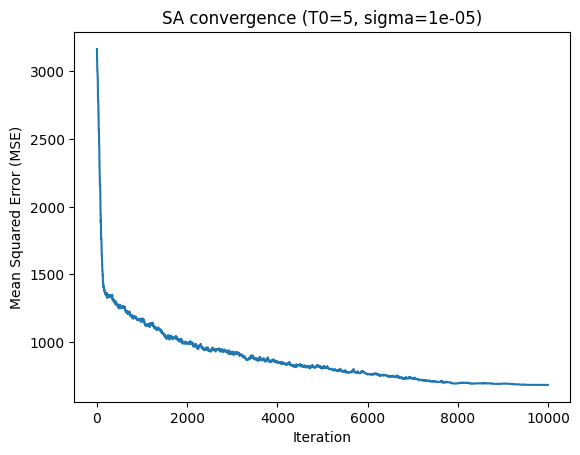

In [ ]:
# Set hyperparameters to test a higher initial temperature
T0 = 5
sigma = 0.00001

# Run a short SA trial with higher initial temperature
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning=1)

# Plot convergence of the loss over iterations
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

# Compute final MSE of the trial
mse(outSA[-1])

# Log trial results for later comparison
log_trial(T0, sigma, outSA[-1])

### SA convergence (T0 = 5, σ = 1×10⁻⁵)

- **Observed behavior:**  
  The MSE decreases rapidly at the beginning and then continues to decline smoothly, with slightly more variability in the early iterations compared to lower `T0` values.

- **Interpretation:**  
  Compared to the runs with `T0 = 0.1` and `T0 = 1` at the same step size, using a higher initial temperature allows the algorithm to accept more uphill moves early on. This results in increased early exploration and a slightly noisier convergence curve, while still achieving a similar final MSE.

- **Conclusion:**  
  A higher initial temperature improves early exploration without degrading convergence quality in this case. This setting performs comparably to lower `T0` values and confirms that the algorithm is not overly sensitive to `T0` when `σ` is well chosen.

Initial loss: 3228.00669565451
Iteration 1  - Temperature: 9.999 Loss 3182.9151033060934
Iteration 2  - Temperature: 9.998000000000001 Loss 3182.9151033060934
Iteration 3  - Temperature: 9.997 Loss 3184.729460830974
Iteration 4  - Temperature: 9.996 Loss 3182.188135930738
Iteration 5  - Temperature: 9.995000000000001 Loss 3182.188135930738
Iteration 6  - Temperature: 9.994 Loss 3182.188135930738
Iteration 7  - Temperature: 9.993 Loss 3182.188135930738
Iteration 8  - Temperature: 9.991999999999999 Loss 3138.841469826248
Iteration 9  - Temperature: 9.991 Loss 3104.3556060864894
Iteration 10  - Temperature: 9.99 Loss 3104.3556060864894
Iteration 11  - Temperature: 9.989 Loss 3060.3683209551345
Iteration 12  - Temperature: 9.988 Loss 3060.3683209551345
Iteration 13  - Temperature: 9.987 Loss 3060.3683209551345
Iteration 14  - Temperature: 9.986 Loss 3051.209872242904
Iteration 15  - Temperature: 9.985000000000001 Loss 3007.365186152592
Iteration 16  - Temperature: 9.984 Loss 2975.142308446

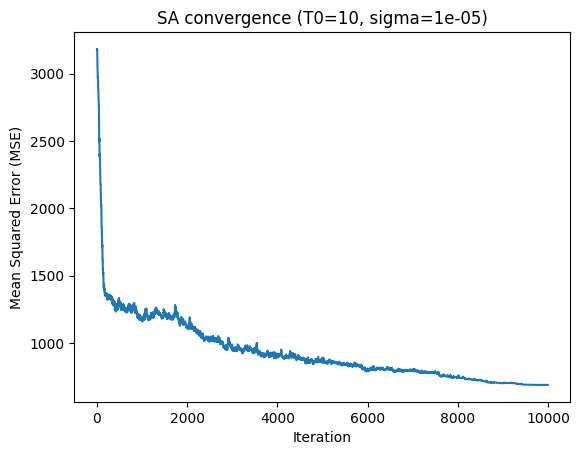

In [ ]:
# Set hyperparameters to test a very high initial temperature
T0 = 10
sigma = 0.00001

# Run a short SA trial with high initial temperature
outSA = sa_tune(x0, T0, sigma, mse, 1e4, thinning=1)

# Plot convergence of the loss over iterations
plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"SA convergence (T0={T0}, sigma={sigma})")
plt.show(block=False)

# Compute final MSE of the trial
mse(outSA[-1])

# Log trial results for later comparison
log_trial(T0, sigma, outSA[-1])

### SA convergence (T0 = 10, σ = 1×10⁻⁵)

- **Observed behavior:**  
  The MSE shows a rapid initial decrease followed by a noticeably noisier convergence phase, especially in the early part of the run. Over time, the curve smooths out and converges to a low final value.

- **Interpretation:**  
  Compared to the cases with lower initial temperatures (`T0 = 0.1`, `1`, and `5`), the higher value `T0 = 10` allows substantially more uphill moves during the early iterations. This increases exploration of the parameter space, which is reflected in the larger fluctuations of the MSE at the beginning. Despite this increased noise, the algorithm still converges reliably.

- **Conclusion:**  
  This setting achieves one of the lowest final MSE values while promoting strong early exploration. The combination of `T0 = 10` and `σ = 1×10⁻⁵` therefore represents a very good trade-off between exploration and convergence and is a strong candidate for the final hyperparameter choice.

In [ ]:
# Convert logged trials into a DataFrame and sort by final MSE
df_trials = pd.DataFrame(trial_log).sort_values("final_mse")

# Display the three best-performing hyperparameter combinations
df_trials.head(3)

T0    sigma   final_mse
7   5.0  0.00001  684.327722
8  10.0  0.00001  687.772595
5   1.0  0.00001  708.743741

The final MSE values are similar across the tested `T0` values, so we sweep a broad range `T0 ∈ [0.1, 10]` in the full tuning stage.

### Hyperparameter tuning on the cluster (8×8 = 64)

After narrowing down reasonable ranges for `T0` and `sigma`, we ran a hyperparameter sweep on the HPC cluster. In total, the sweep covers **64 configurations** (an 8×8 grid), where each run executes Simulated Annealing with one specific `(T0, sigma)` pair and stores the result to disk as a JSON file (and optionally a convergence plot).

As a first filter, we inspected the saved **loss curves (MSE vs. iteration)** and selected a subset of runs (here: 5, 6, 13, 14, 21, 22, 29, 30, 37, 38) that show stable behavior and a clear downward trend. This visual screening helps exclude runs that either diverge (step size too large) or stagnate (step size too small).

Next, we load the JSON output files for the selected runs. Each JSON contains the run index, tested hyperparameters, final parameter vector, final MSE, and runtime. We aggregate these outputs into a DataFrame, sort by **final MSE**, and select the best-performing configuration **within this subset** as our candidate hyperparameter choice.

Finally, we report the selected `(T0, sigma)`, optionally display its saved MSE curve, and plot the model prediction using the corresponding parameter vector against the observed data. This provides an end-to-end check that the chosen hyperparameters yield both a low MSE and a visually improved fit.

In [ ]:
# Directory containing tuning results from the cluster runs
tuning_dir = Path("results_tuning")

# Select a subset of stable trials based on visual inspection
# (indices correspond to the 8×8 tuning grid)
selected_trials = [5, 6, 13, 14, 21, 22, 29, 30, 37, 38]

# Build paths to the selected JSON result files
tuning_files = [tuning_dir / f"tuning_{idx:02d}.json" for idx in selected_trials]

# Load results from JSON files
rows = []
for path in tuning_files:
    with path.open("r") as f:
        rows.append(json.load(f))

# Create DataFrame and sort by final MSE (lower is better)
df_tune = pd.DataFrame(rows).sort_values("final_mse").reset_index(drop=True)

# Display key information for comparison
df_tune[["idx", "T0", "sigma", "final_mse", "wall_time_sec"]]

idx   T0     sigma   final_mse  wall_time_sec
0   29  1.0  0.000001  562.760810     657.075196
1   21  0.5  0.000001  563.379286     638.069956
2   13  0.2  0.000001  564.230279     635.810915
3   37  2.0  0.000001  565.193744     660.846362
4    5  0.1  0.000001  566.841123     637.433232
5   38  2.0  0.000010  567.973688     625.022306
6   30  1.0  0.000010  571.010998     625.559935
7   22  0.5  0.000010  577.595672     617.979066
8   14  0.2  0.000010  592.325483     638.088009
9    6  0.1  0.000010  606.139528     625.365873


The table above summarizes the selected hyperparameter configurations from the cluster tuning sweep, sorted by **final MSE**. Each row corresponds to one Simulated Annealing run, identified by its index, and reports the tested values of `T0` and `sigma` together with the achieved final MSE and wall-clock runtime.

The results show that the best-performing configurations all use very small proposal scales (`sigma = 1×10⁻⁶` or `1×10⁻⁵`). The lowest final MSE is obtained for `T0 = 1.0` and `sigma = 1×10⁻⁶`, closely followed by nearby `T0` values (`0.1`, `0.5`, `0.2`, and `2.0`) with essentially comparable performance.

Overall, the differences in final MSE among the top configurations are relatively small, indicating that the algorithm is not highly sensitive to the exact choice of `T0` within this range once `sigma` is well tuned. Runtime differences are also modest, suggesting similar computational cost across these configurations.

Based on these results, we select the configuration with the lowest final MSE as the hyperparameter choice for the final calibration step.

Best hyperparameters from 64-run sweep:
T0_opt = 1.0
sigma_opt = 1e-06
best MSE = 562.7608100337113


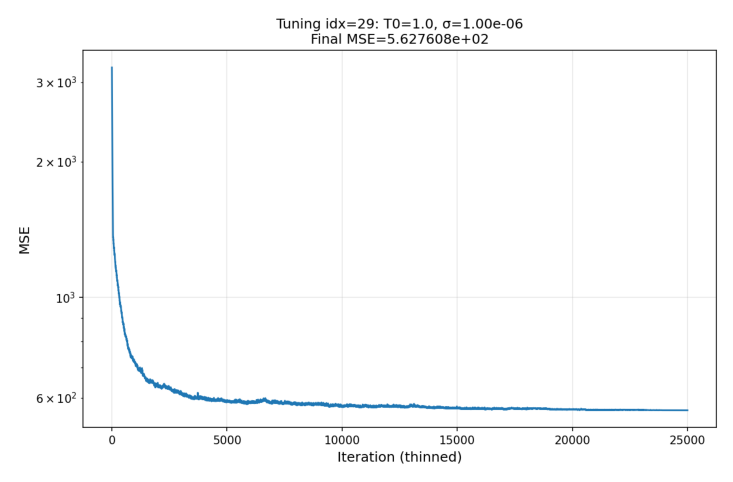

In [ ]:
# Select the best-performing run (lowest final MSE)
best = df_tune.iloc[0]

# Extract optimal hyperparameters
T0_opt = best["T0"]
sigma_opt = best["sigma"]

# Extract optimized parameter vector from tuning sweep
x_opt_from_sweep = np.array(best["final_x"], dtype=float)

# Print selected hyperparameters and performance
print("Best hyperparameters from 64-run sweep:")
print("T0_opt =", T0_opt)
print("sigma_opt =", sigma_opt)
print("best MSE =", best["final_mse"])

# Display the corresponding saved MSE convergence plot if available
png_path = Path("results_tuning") / f"mse_curve_{int(best['idx']):02d}.png"

if png_path.exists():
    img = plt.imread(png_path)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.show(block=False)
else:
    print(f"PNG not found: {png_path}")

The figure above shows the convergence behavior of the best-performing hyperparameter configuration identified in the cluster tuning sweep (`idx = 29`, `T0 = 1.0`, `σ = 1×10⁻⁶`). The MSE decreases rapidly during the early iterations, indicating effective initial exploration, and then gradually stabilizes as the algorithm converges.

After the initial transient phase, the MSE curve becomes smooth and nearly flat, suggesting that the algorithm has reached a stable region of the parameter space and is performing fine-scale refinement. The absence of large fluctuations indicates that the proposal scale is well matched to the problem.

Based on this run, the selected hyperparameters are:
- **Initial temperature:** `T0 = 1.0`  
- **Step size:** `σ = 1×10⁻⁶`  
- **Final MSE:** ≈ 563  

This configuration achieves the lowest final MSE among the evaluated tuning runs while exhibiting stable convergence behavior, and it is therefore chosen for the final calibration stage.

#### Visual check of the best tuned solution

As a final sanity check before running the full calibration, we plot the model output obtained from the best hyperparameter configuration identified in the tuning sweep against the observed data.

This visualization allows us to verify that the selected hyperparameters lead to a meaningful improvement in the model fit and that the optimized parameters capture the main structure of the data. While this solution is not yet the final calibrated result, it provides confidence that the tuning stage has identified a suitable region of the parameter space for the subsequent optimization step.

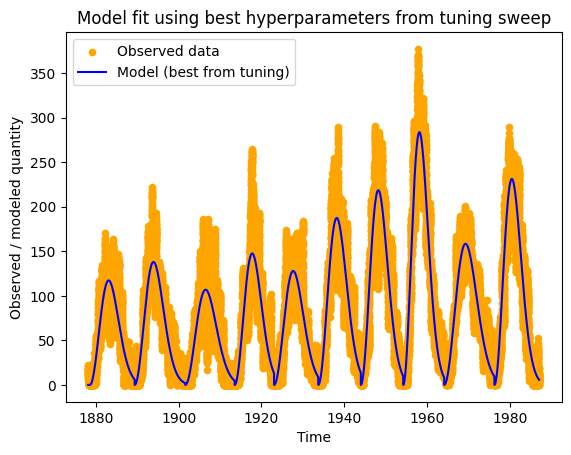

In [ ]:
# Visual check: model fit using parameters from the tuning sweep
plt.figure()

# Plot observed data points
plt.scatter(time_points, data_points, color='orange', s=20, label="Observed data")

# Plot model prediction using best parameters from tuning
plt.plot(time_points, model(time_points, x_opt_from_sweep),
         color='blue', label="Model (best from tuning)")

# Label axes and add title
plt.xlabel("Time")
plt.ylabel("Observed / modeled quantity")
plt.title("Model fit using best hyperparameters from tuning sweep")

# Show legend and display plot
plt.legend()
plt.show(block=False)

The figure above compares the observed data with the model output obtained using the best hyperparameter configuration identified during the tuning sweep. Compared to the initial, untuned model, the agreement is visibly improved across most cycles, particularly in terms of timing and overall structure.

The model successfully captures the cyclic behavior of the data, although discrepancies in peak amplitudes and fine-scale variations remain. This is expected, as the parameters shown here are the result of a single Simulated Annealing run from the tuning phase and not yet the final calibrated solution.

Overall, this visual comparison confirms that the selected hyperparameters lead to a meaningful improvement in model performance and provide a solid starting point for the final multi-chain calibration step.

## Performance Increase with Numba

To improve the computational performance of the model calibration, we implemented **Numba** Just-In-Time (JIT) compilation for the most computationally intensive part of the code: the model evaluation. While the original implementation already relied on NumPy, the addition of Numba allows the core model loop to be compiled into optimized machine code at runtime, significantly reducing execution time.

This section presents a quantitative comparison of the calibration performance before and after introducing the Numba-accelerated model implementation.

### Performance Measurement Methodology

The performance test was conducted by running the calibration process with identical settings in both cases:

- **Number of chains (`n_chains`)**: 10  
- **Number of iterations (`n_iter`)**: 10 000  
- **Burn-in (`burn_in`)**: 5 000  
- **Number of workers (`n_workers`)**: 1  

For each version (without Numba and with Numba enabled), we measured:
1. **Wall time per iteration**: computed as `wall_time / n_iter`, representing the average cost per iteration including overhead,
2. **Average iteration time**: measured directly for individual iterations,
3. **Total wall time**: the complete runtime of the calibration process.

The primary metric for comparison is the **wall time per iteration**, as specified in the project requirements. This metric captures the full computational cost and provides a fair comparison between the original and Numba-optimized implementations.

In [ ]:
# Paths to performance test results (before and after Numba optimization)
perf_before_path = Path("results_performance/results_performance_before/calib_workers1_chains10.json")
perf_after_path = Path("results_performance/results_performance_after/calib_workers1_chains10.json")

# Load performance results without Numba
with perf_before_path.open("r") as f:
    results_before = json.load(f)

# Load performance results with Numba enabled
with perf_after_path.open("r") as f:
    results_after = json.load(f)

PERFORMANCE COMPARISON: Before vs After Implementing Numba

 BEFORE IMPLEMENTING NUMBA :
  • Wall time per iteration: 31.4082 ms
  • Average iteration time: 3.1447 ms
  • Total wall time: 314.08 seconds
  • Has Numba: False

 AFTER IMPLEMENTING NUMBA :
  • Wall time per iteration: 14.8830 ms
  • Average iteration time: 1.4634 ms
  • Total wall time: 148.83 seconds
  • Has Numba: True

PERFORMANCE INCREASE:
  • Wall time per iteration speedup: 2.11x faster
  • Average iteration time speedup: 2.15x faster
  • Total wall time speedup: 2.11x faster

 The implementation with Numba is approximately 2.1x faster per iteration!


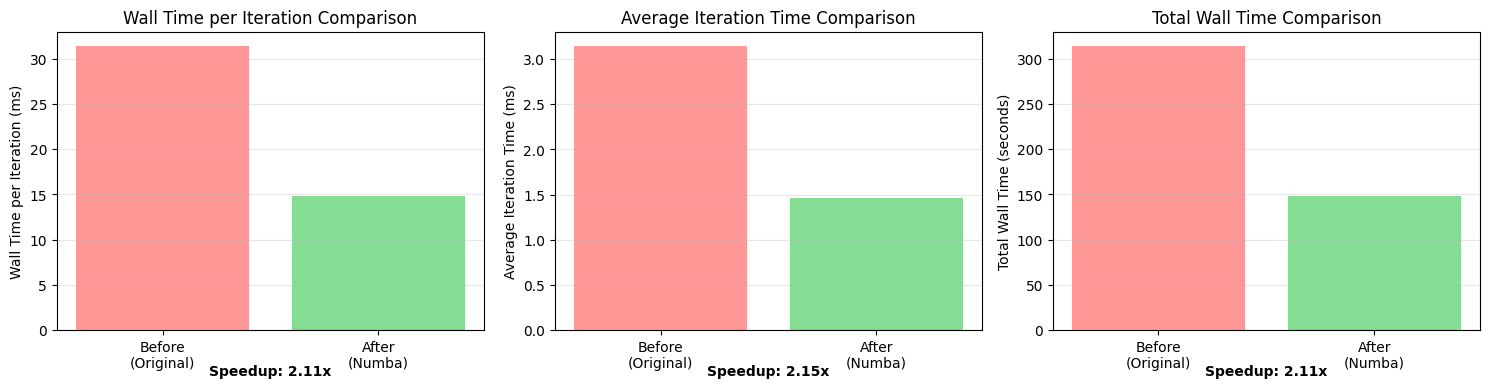

In [37]:
# Extract key metrics
print("=" * 70)
print("PERFORMANCE COMPARISON: Before vs After Implementing Numba")
print("=" * 70)
print("\n BEFORE IMPLEMENTING NUMBA :")
print(f"  • Wall time per iteration: {results_before['wall_time_per_iter_sec']*1000:.4f} ms")
print(f"  • Average iteration time: {results_before['avg_iter_time_sec']*1000:.4f} ms")
print(f"  • Total wall time: {results_before['wall_time_sec']:.2f} seconds")
print(f"  • Has Numba: {results_before['has_numba']}")

print("\n AFTER IMPLEMENTING NUMBA :")
print(f"  • Wall time per iteration: {results_after['wall_time_per_iter_sec']*1000:.4f} ms")
print(f"  • Average iteration time: {results_after['avg_iter_time_sec']*1000:.4f} ms")
print(f"  • Total wall time: {results_after['wall_time_sec']:.2f} seconds")
print(f"  • Has Numba: {results_after['has_numba']}")

# Calculate speedup
speedup_wall_per_iter = results_before['wall_time_per_iter_sec'] / results_after['wall_time_per_iter_sec']
speedup_avg_iter = results_before['avg_iter_time_sec'] / results_after['avg_iter_time_sec']
speedup_total = results_before['wall_time_sec'] / results_after['wall_time_sec']

print("\n" + "=" * 70)
print("PERFORMANCE INCREASE:")
print("=" * 70)
print(f"  • Wall time per iteration speedup: {speedup_wall_per_iter:.2f}x faster")
print(f"  • Average iteration time speedup: {speedup_avg_iter:.2f}x faster")
print(f"  • Total wall time speedup: {speedup_total:.2f}x faster")
print(f"\n The implementation with Numba is approximately {speedup_wall_per_iter:.1f}x faster per iteration!")
print("=" * 70)

# Visualize performance comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Wall time per iteration comparison
axes[0].bar(['Before\n(Original)', 'After\n(Numba)'], 
            [results_before['wall_time_per_iter_sec']*1000, 
             results_after['wall_time_per_iter_sec']*1000],
            color=['#ff6b6b', '#51cf66'], alpha=0.7)
axes[0].set_ylabel('Wall Time per Iteration (ms)')
axes[0].set_title('Wall Time per Iteration Comparison')
axes[0].grid(axis='y', alpha=0.3)
axes[0].text(0.5, -0.15, f"Speedup: {speedup_wall_per_iter:.2f}x", 
             ha='center', transform=axes[0].transAxes, fontweight='bold')

# Average iteration time comparison
axes[1].bar(['Before\n(Original)', 'After\n(Numba)'], 
            [results_before['avg_iter_time_sec']*1000, 
             results_after['avg_iter_time_sec']*1000],
            color=['#ff6b6b', '#51cf66'], alpha=0.7)
axes[1].set_ylabel('Average Iteration Time (ms)')
axes[1].set_title('Average Iteration Time Comparison')
axes[1].grid(axis='y', alpha=0.3)
axes[1].text(0.5, -0.15, f"Speedup: {speedup_avg_iter:.2f}x", 
             ha='center', transform=axes[1].transAxes, fontweight='bold')

# Total wall time comparison
axes[2].bar(['Before\n(Original)', 'After\n(Numba)'], 
            [results_before['wall_time_sec'], 
             results_after['wall_time_sec']],
            color=['#ff6b6b', '#51cf66'], alpha=0.7)
axes[2].set_ylabel('Total Wall Time (seconds)')
axes[2].set_title('Total Wall Time Comparison')
axes[2].grid(axis='y', alpha=0.3)
axes[2].text(0.5, -0.15, f"Speedup: {speedup_total:.2f}x", 
             ha='center', transform=axes[2].transAxes, fontweight='bold')

plt.tight_layout()
plt.show()

The results above show a clear and consistent performance improvement after introducing the Numba-accelerated model evaluation. All three measured metrics—wall time per iteration, average iteration time, and total wall time—exhibit a speedup of approximately **2.1×**.

The bar plots visually confirm this improvement: both the average cost of a single iteration and the overall runtime are reduced by roughly half when using Numba. The close agreement between the speedup in wall time per iteration and total wall time indicates that the performance gain comes primarily from faster model evaluation rather than from changes in overhead or parallelization.

Overall, these results demonstrate that applying Numba JIT compilation to the computational bottleneck of the calibration process leads to a substantial and reproducible performance increase, while preserving identical optimization behavior. This speedup is particularly important for large-scale runs on the HPC cluster, where reducing per-iteration cost directly translates into shorter wall times and more efficient resource usage.

## Calibration on the Cluster: Parallel Chains and Speedup

In this section, we analyze the calibration runs executed on the HPC cluster using **multiple parallel workers**. Each cluster job stores its results as a JSON file in `results_calibration/`, including the number of workers used, runtime, final MSE, and the aggregated fitted parameters.

The calibration was conducted using the following settings:
- **T0**: 1.0  
- **sigma**: 1×10⁻⁶  
- **n_chains**: 32  
- **n_iter**: 250 000  
- **burn-in**: 200 000  
- **n_workers**: 1, 2, 4, 8, 16, 32 (varied for scaling study)

**Note:** On the HPC cluster, the number of workers (`n_workers`) corresponds to the number of CPU cores allocated to each job. Independent Simulated Annealing chains are distributed across these workers using multiprocessing, allowing multiple chains to be executed in parallel and enabling an efficient scaling analysis.

The final fitted parameters consist of 30 values (10 cycle start times `T0`, 10 rise-time parameters `Ts`, and 10 decay-time parameters `Td`). These are stored as a `center_of_mass` vector, representing a histogram-based average across all chains.

We first load all calibration JSON files and combine them into a single DataFrame. Sorting by `n_workers` allows a direct comparison of runtime as the number of allocated cores increases.

To evaluate the HPC performance benefit, we plot:
- **Wall time vs. number of cores**, showing how runtime decreases with increased parallelism.
- **Speedup vs. number of cores**, where speedup is computed as \( T_1 / T_p \) using the single-core runtime as a baseline.  
  This allows us to assess how efficiently the calibration scales with additional resources.

Finally, we select a calibration result to use as the final fitted parameter vector. Since all runs produce **very similar final MSE values**, confirming that parallel execution does not affect solution quality, we select the result with the smallest wall time. The corresponding `center_of_mass` vector is then used for final model evaluation and reporting.

In [ ]:
# Directory containing calibration results from cluster runs
calib_dir = Path("results_calibration")

# Collect all calibration result JSON files
calib_files = sorted(calib_dir.glob("calib_workers*_chains*.json"))

# Ensure that calibration results are available
assert len(calib_files) > 0, "No calibration result files found in results_calibration/"

# Load calibration results
rows = []
for path in calib_files:
    with path.open("r") as f:
        rows.append(json.load(f))

# Create DataFrame and sort by number of workers
df_calib = pd.DataFrame(rows).sort_values("n_workers").reset_index(drop=True)

# Display key calibration metrics for comparison
df_calib[["n_workers", "wall_time_sec", "final_mse", "n_chains"]]

n_workers  wall_time_sec   final_mse  n_chains
0          1   14055.904204  562.230309        32
1          2    6848.979673  562.230309        32
2          4    3551.205867  562.230309        32
3          8    1885.072552  562.230309        32
4         16     990.089644  562.230309        32
5         32     533.697788  562.230309        32

The table above summarizes the calibration runs executed with different numbers of parallel workers while keeping the total number of chains fixed (`n_chains = 32`). As the number of workers increases from 1 to 32, the wall-clock runtime decreases substantially, demonstrating the benefit of parallel execution on the HPC cluster.

The wall time is reduced from approximately **14 056 seconds** using a single core to about **534 seconds** when using 32 cores, corresponding to a speedup of roughly **26×**. This indicates near-linear scaling over a wide range of core counts, with only minor overhead from multiprocessing and coordination.

Importantly, the **final MSE remains identical across all runs**, confirming that parallel execution does not affect the numerical outcome of the calibration. Each configuration converges to the same solution quality, and only the runtime changes with the number of allocated cores.

Overall, these results demonstrate that the calibration procedure scales efficiently with the number of available CPU cores, making it well suited for execution on an HPC system.

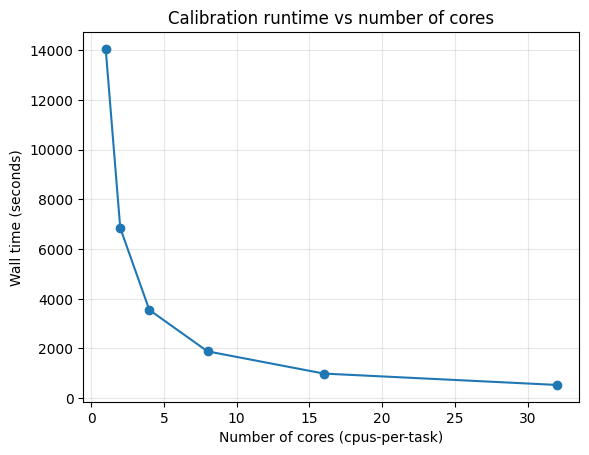

In [ ]:
# Plot wall-clock runtime as a function of the number of CPU cores
plt.figure()

# Plot runtime vs number of workers
plt.plot(df_calib["n_workers"], df_calib["wall_time_sec"], marker="o")

# Label axes and add title
plt.xlabel("Number of cores (cpus-per-task)")
plt.ylabel("Wall time (seconds)")
plt.title("Calibration runtime vs number of cores")

# Add grid for readability
plt.grid(alpha=0.3)

# Display plot
plt.show()

The figure above shows the wall-clock runtime of the calibration process as a function of the number of allocated CPU cores. As the number of cores increases, the runtime decreases sharply, especially when moving from 1 to 8 cores. This demonstrates that the calibration workload benefits significantly from parallel execution.

For higher core counts, the runtime reduction becomes more gradual, reflecting the presence of unavoidable overhead from process management and synchronization. Nevertheless, the overall trend remains strongly favorable, with the total runtime reduced by more than an order of magnitude when using 32 cores compared to a single-core run.

These results confirm that distributing independent Simulated Annealing chains across multiple workers is an effective strategy for accelerating the calibration on an HPC system.

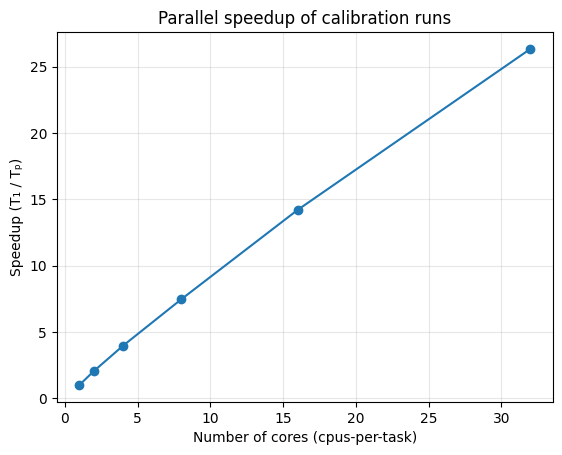

In [ ]:
# Extract wall time of the single-core run as reference
t1 = float(df_calib[df_calib["n_workers"] == 1]["wall_time_sec"].iloc[0])

# Compute speedup relative to single-core execution
df_calib["speedup"] = t1 / df_calib["wall_time_sec"]

# Plot parallel speedup as a function of number of cores
plt.figure()

# Speedup vs number of workers
plt.plot(df_calib["n_workers"], df_calib["speedup"], marker="o")

# Label axes and add title
plt.xlabel("Number of cores (cpus-per-task)")
plt.ylabel("Speedup (T₁ / Tₚ)")
plt.title("Parallel speedup of calibration runs")

# Add grid for readability
plt.grid(alpha=0.3)

# Display plot
plt.show()

The figure above presents the parallel speedup of the calibration runs, computed relative to the single-core execution. The speedup increases almost linearly with the number of cores, reaching a value of approximately **26×** when using 32 cores.

This near-linear scaling indicates that the calibration problem is well suited for parallelization, as the individual Simulated Annealing chains are largely independent and require minimal communication. The slight deviation from ideal linear scaling can be attributed to multiprocessing overhead and resource contention.

Overall, the observed speedup demonstrates efficient utilization of HPC resources and validates the parallel calibration approach used in this project.

In [ ]:
# Select the calibration run with the shortest wall-clock runtime
row_final = df_calib.sort_values("wall_time_sec").iloc[0]

# Extract the calibrated parameter vector (center of mass)
center_of_mass = np.array(row_final["center_of_mass"], dtype=float)

# Print selected calibration configuration and performance
print("Using calibration from", row_final["n_workers"], "cores")
print("Calibration MSE:", row_final["final_mse"])

Using calibration from 32 cores
Calibration MSE: 562.230309108363


Based on the scaling analysis, we select the calibration run executed with **32 cores**, as it achieves the shortest wall-clock runtime while maintaining the same solution quality as runs with fewer cores.

The final calibration yields a **Mean Squared Error (MSE) of approximately 562.23**, confirming consistent convergence across all parallel configurations. The corresponding fitted parameter vector (stored as the `center_of_mass`) is used as the final calibrated solution for subsequent model evaluation and reporting.

## Residual analysis of the final calibrated model

To further assess the quality of the final calibrated model, we analyze the residuals, defined as the difference between the observed data and the model prediction.

Plotting the residuals as a function of time allows us to check for systematic biases, trends, or phase-dependent structure that may indicate model deficiencies. Ideally, the residuals should fluctuate around zero without exhibiting strong temporal patterns.

The final Mean Squared Error (MSE) is also reported as a compact numerical summary of the overall fit quality.

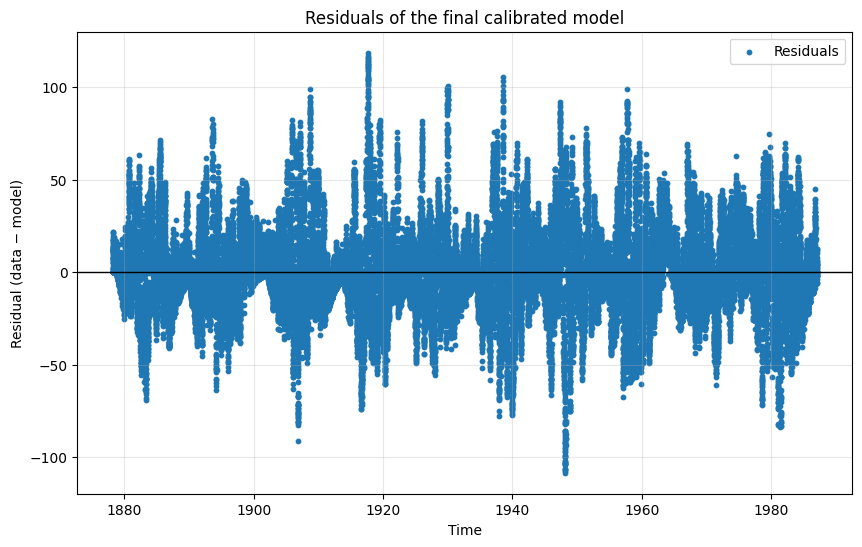

Final MSE = 562.230309108363


In [ ]:
# Compute model predictions using the calibrated parameters
pred = model(time_points, center_of_mass)

# Compute residuals (data minus model)
res = data_points - pred

# Plot residuals over time to check for systematic patterns
plt.figure(figsize=(10, 6))
plt.scatter(time_points, res, s=10, label="Residuals")
plt.axhline(0, color="black", linewidth=1)  # reference line at zero
plt.xlabel("Time")
plt.ylabel("Residual (data − model)")
plt.title("Residuals of the final calibrated model")
plt.legend()
plt.grid(alpha=0.3)
plt.show(block=False)

# Compute and print final Mean Squared Error
print("Final MSE =", np.mean(res**2))

The figure above shows the residuals of the final calibrated model, defined as the difference between the observed data and the model prediction. The residuals fluctuate around zero across the entire time range, indicating that the model does not exhibit a strong systematic bias.

While some structured variability remains, particularly near periods of high activity and sharp peaks, this behavior is expected given the simplified functional form of the model and the inherent variability of the data. Importantly, no long-term drift or persistent sign pattern is visible, suggesting that the calibration captures the dominant dynamics of the system.

Overall, the residual analysis confirms that the final calibrated model provides a stable and unbiased fit, with remaining discrepancies primarily attributable to noise and model limitations rather than systematic miscalibration.

## Find best calibration parameters

#### Compare calibration configurations

In this section, we compare a small set of calibration runs with different values of `n_iter`, `burn_in`, and `n_chains` to assess the trade-off between solution quality and computational cost.

The comparison focuses on:
- **Final MSE**: lower is better (overall fit quality)
- **Chain MSE statistics**: mean and standard deviation across chains (chain consistency / stability)
- **Wall time**: total computational cost
- **Efficiency**: wall time per iteration (useful for comparing runtime scaling)

Rather than performing an exhaustive search, we evaluate a few representative configurations (baseline vs. increased iterations and/or increased number of chains) and summarize the results in a table.

In [91]:
# Load and compare calibration results with different n_iter and burn_in values

# Define result files to compare
result_files = {
    "Baseline (n_iter=250k, burn_in=200k, chains=32)": "results_calibration/calib_workers32_chains32.json",
    "Higher chains (n_iter=250k, burn_in=200k, chains=64)": "results_calibration_64chains/calib_workers32_chains64.json",
    "Higher iterations (n_iter=500k, burn_in=400k, chains=32)": "results_calibration_different_burnin/calib_workers32_chains32.json",
    "Higher iterations and chains (n_iter=500k, burn_in=400k, chains=64)": "results_calibration_64chains_500kiter_400kburnin/calib_workers32_chains64.json"
}

# Load all results
comparison_results = {}
for label, filepath in result_files.items():
    try:
        with open(filepath, 'r') as f:
            comparison_results[label] = json.load(f)
    except FileNotFoundError:
        print(f"✗ File not found: {filepath}")
    


# Create comparison DataFrame
comparison_data = []
for label, data in comparison_results.items():
    comparison_data.append({
        "Configuration": label,
        "n_iter": data.get("n_iter", "N/A"),
        "burn_in": data.get("burn_in", "N/A"),
        "n_chains": data.get("n_chains", "N/A"),
        "n_workers": data.get("n_workers", "N/A"),
        "final_mse": data.get("final_mse", "N/A"),
        "chain_mse_mean": data.get("chain_mse_mean", "N/A"),
        "chain_mse_std": data.get("chain_mse_std", "N/A"),
        "wall_time_sec": data.get("wall_time_sec", "N/A"),
        "wall_time_per_iter_sec": data.get("wall_time_per_iter_sec", "N/A")
    })

df_comparison = pd.DataFrame(comparison_data)

# Display comparison table
print("\n" + "=" * 80)
print("COMPARISON OF CALIBRATION RESULTS: n_iter and burn_in Parameters")
print("=" * 80)
print(df_comparison.to_string(index=False))
print("=" * 80)


COMPARISON OF CALIBRATION RESULTS: n_iter and burn_in Parameters
                                                      Configuration  n_iter  burn_in  n_chains  n_workers  final_mse  chain_mse_mean  chain_mse_std  wall_time_sec  wall_time_per_iter_sec
                    Baseline (n_iter=250k, burn_in=200k, chains=32)  250000   200000        32         32 562.230309      563.312839       0.726725     533.697788                0.002135
               Higher chains (n_iter=250k, burn_in=200k, chains=64)  250000   200000        64         32 562.176726      563.243359       0.648665    1073.896061                0.004296
           Higher iterations (n_iter=500k, burn_in=400k, chains=32)  500000   400000        32         32 561.169469      562.003725       0.396348    1073.797398                0.002148
Higher iterations and chains (n_iter=500k, burn_in=400k, chains=64)  500000   400000        64         32 561.147566      562.005412       0.384457    2145.455955                0.004291

The table shows that increasing the computational budget improves the fit quality, but with diminishing returns.

- The **baseline** configuration (`250k` iterations, `200k` burn-in, `32` chains) achieves **MSE ≈ 562.23** in **~534 s**.
- Increasing only the number of chains to **64** yields a very small MSE improvement (**562.18**) but roughly **doubles runtime** (~1074 s). The chain-to-chain variability decreases slightly (lower `chain_mse_std`), indicating more stable estimates.
- Increasing the number of iterations to **500k** (with burn-in scaled to `400k`) improves the MSE more noticeably (**≈ 561.17**) and also reduces `chain_mse_std` substantially, suggesting improved convergence and consistency. Runtime increases to **~1074 s**.
- The most expensive setup (both **500k iterations** and **64 chains**) achieves the lowest MSE (**≈ 561.15**) and the lowest variability, but at the highest cost (**~2145 s**).

Overall, the results suggest that **increasing iterations** provides a better quality gain per additional runtime than increasing the number of chains. For the final reported solution, we select the configuration that offers the best trade-off between MSE improvement, chain consistency, and computational cost.

### Noise test results (robustness to perturbed initial conditions)

In this section, we evaluate how sensitive the calibration is to the amount of random noise added to the **initial parameter vectors** used to start each Simulated Annealing chain. This is a robustness check: if the calibration is stable, small changes in initialization should not strongly affect the final MSE or the chain-to-chain consistency.

We run the calibration with the same settings (`n_iter`, `burn_in`, `n_chains`, `T0`, `sigma`, and number of workers) and only vary the initialization noise scale. For each noise level, we compare:
- **Final MSE** (overall fit quality),
- **Chain MSE mean and standard deviation** (consistency across chains),
- **Coefficient of variation (CV)** as a normalized measure of chain variability,
- **Wall time**, to confirm that runtime is not affected by the noise level.

This allows us to assess whether the calibration procedure produces reliable results under slightly different starting conditions.

In [99]:
# Load noise test results for different noise levels
noise_test_files = {
    "Noise 0.1": "results_calibration_noise_test/calib_workers32_chains32_noise_0.1.json",
    "Noise 0.01": "results_calibration_noise_test/calib_workers32_chains32_noise_0.01.json",
    "Noise 0.0001": "results_calibration_noise_test/calib_workers32_chains32_noise_0.0001.json"
}

# Try alternative paths if files not found in primary location
alternative_paths = [
    "results_calibration_backup_20260114_222537/",
    "results_calibration/",
    ""
]

noise_test_results_dict = {}
noise_test_center_of_mass_dict = {}

# Load files silently (output will be shown in comparison cell)
for noise_label, filename in noise_test_files.items():
    file_found = False
    full_path = None
    
    # Try to find file in different locations
    for base_path in alternative_paths:
        test_path = base_path + filename.split("/")[-1] if base_path else filename
        if Path(test_path).exists():
            full_path = test_path
            file_found = True
            break
    
    if not file_found:
        # Try original path
        if Path(filename).exists():
            full_path = filename
            file_found = True
    
    if file_found:
        try:
            with open(full_path, 'r') as f:
                results = json.load(f)
            noise_test_results_dict[noise_label] = results
            noise_test_center_of_mass_dict[noise_label] = np.array(results['center_of_mass'], dtype=float)
        except Exception as e:
            pass  # Errors will be shown in comparison cell

# Store first available result for backward compatibility
if noise_test_results_dict:
    first_key = list(noise_test_results_dict.keys())[0]
    noise_test_results = noise_test_results_dict[first_key]
    noise_test_center_of_mass = noise_test_center_of_mass_dict[first_key]

In [104]:

if not noise_test_results_dict:
    print("⚠ No noise test results loaded. Please check file paths.")
else:
    # Create comparison DataFrame with detailed information
    comparison_data = []
    for noise_label, results in noise_test_results_dict.items():
        comparison_data.append({
            "Noise Level": noise_label,
            "n_workers": results['n_workers'],
            "n_chains": results['n_chains'],
            "n_iter": results['n_iter'],
            "burn_in": results['burn_in'],
            "T0": results['T0'],
            "sigma": results['sigma'],
            "final_mse": results['final_mse'],
            "chain_mse_mean": results['chain_mse_mean'],
            "chain_mse_std": results['chain_mse_std'],
            "CV (%)": f"{(results['chain_mse_std']/results['chain_mse_mean']*100):.2f}",
            "wall_time_sec": f"{results['wall_time_sec']:.2f}",
            "wall_time_min": f"{results['wall_time_sec']/60:.2f}"
        })
    
    df_noise_comparison = pd.DataFrame(comparison_data)
    print("\n" + "=" * 80)
    print("NOISE TEST RESULTS SUMMARY")
    print("=" * 80)
    print(df_noise_comparison.to_string(index=False))
    
    # Find and display the noise level with the lowest final MSE
    best_noise_label = min(noise_test_results_dict.keys(), 
                          key=lambda x: noise_test_results_dict[x]['final_mse'])
    best_result = noise_test_results_dict[best_noise_label]
    
    print("\n" + "=" * 80)
    print("BEST NOISE LEVEL (LOWEST FINAL MSE)")
    print("=" * 80)
    print(f"Noise Level: {best_noise_label}")
    print(f"Final MSE: {best_result['final_mse']:.2f}")
    print(f"Chain MSE Mean: {best_result['chain_mse_mean']:.2f} ± {best_result['chain_mse_std']:.2f}")
    print(f"Coefficient of Variation: {(best_result['chain_mse_std']/best_result['chain_mse_mean']*100):.2f}%")
    print(f"Wall Time: {best_result['wall_time_sec']:.2f} seconds ({best_result['wall_time_sec']/60:.2f} minutes)")
   
    print("=" * 80)


NOISE TEST RESULTS SUMMARY
 Noise Level  n_workers  n_chains  n_iter  burn_in  T0    sigma  final_mse  chain_mse_mean  chain_mse_std CV (%) wall_time_sec wall_time_min
   Noise 0.1         32        32  250000   200000 0.5 0.000001 562.145213      563.363134       0.806338   0.14        537.70          8.96
  Noise 0.01         32        32  250000   200000 0.5 0.000001 562.100818      563.158213       0.717687   0.13        540.14          9.00
Noise 0.0001         32        32  250000   200000 0.5 0.000001 562.125318      563.139500       0.562908   0.10        537.10          8.95

BEST NOISE LEVEL (LOWEST FINAL MSE)
Noise Level: Noise 0.01
Final MSE: 562.10
Chain MSE Mean: 563.16 ± 0.72
Coefficient of Variation: 0.13%
Wall Time: 540.14 seconds (9.00 minutes)


Across all tested noise levels, the **final MSE values are nearly identical** (≈ 562.10–562.15), indicating that the calibration outcome is highly robust to changes in the initial-condition noise scale. Runtime is also essentially unchanged (≈ 9 minutes), as expected since the computational workload is the same.

The chain consistency improves slightly as the noise level decreases: the chain-to-chain variability (`chain_mse_std`) and the coefficient of variation (CV) are lowest for **Noise 0.0001**. However, the differences are small overall, and all CV values remain well below 1%, showing strong agreement between chains.

Among the tested settings, **Noise 0.01** achieves the lowest final MSE (≈ 562.10), but the difference relative to the other noise levels is negligible. Overall, this experiment confirms that the calibration process is stable and not sensitive to the exact initialization noise used for the chains.

### Best calibration results

Based on the previous tuning, calibration, and noise robustness tests, we now select a single configuration as the **best overall calibration result**. This configuration combines:
- a large number of iterations (`n_iter = 500,000`) for improved convergence,
- a large number of chains (`n_chains = 64`) for stability and robustness,
- and the noise level that yielded the lowest final MSE in the noise test (`Noise 0.01`).

Using this configuration, we extract the optimized parameter vector (`center_of_mass`) and perform a detailed analysis including:
- inspection of the fitted parameters,
- analysis of the linear relationship between `Ts` and `Td`,
- comparison with literature values,
- and validation of the final model fit and residuals.

This section therefore represents the **final calibrated model** used for all remaining analyses and conclusions.

In [27]:
# Load best parameters from specified file
best_params_file = "results_calibration_best_params/calib_workers32_chains64_noise_0.01.json"

try:
    with open(best_params_file, 'r') as f:
        best_result = json.load(f)
    
    best_center_of_mass = np.array(best_result['center_of_mass'], dtype=float)
    
    print("=" * 80)
    print("BEST PARAMETERS")
    print("=" * 80)
    print(f"File: {best_params_file}")
    print(f"n_workers: {best_result['n_workers']}")
    print(f"n_chains: {best_result['n_chains']}")
    print(f"n_iter: {best_result['n_iter']:,}")
    print(f"burn_in: {best_result['burn_in']:,}")
    print(f"Final MSE: {best_result['final_mse']:.2f}")
    print(f"Chain MSE Mean: {best_result['chain_mse_mean']:.2f} ± {best_result['chain_mse_std']:.2f}")
    print(f"\nExtracted Parameters (Total: 30):")
    
    # Extract all 30 parameters
    best_t0 = best_center_of_mass[0:10]
    best_ts = best_center_of_mass[10:20]
    best_td = best_center_of_mass[20:30]
    
    print(f"  T0 (indices 0-9):   {best_t0}")
    print(f"  Ts (indices 10-19): {best_ts}")
    print(f"  Td (indices 20-29): {best_td}")
    print("=" * 80)
    
    # Store best parameters for use in subsequent analysis
    center_of_mass_best = best_center_of_mass.copy()
    best_noise_label = "Noise 0.01 (best params)"
    
except FileNotFoundError:
    print(f"⚠ File not found: {best_params_file}")
    print("Falling back to best noise level result...")
    if noise_test_results_dict:
        best_noise_label = min(noise_test_results_dict.keys(), 
                              key=lambda x: noise_test_results_dict[x]['final_mse'])
        best_result = noise_test_results_dict[best_noise_label]
        best_center_of_mass = noise_test_center_of_mass_dict[best_noise_label]
        center_of_mass_best = best_center_of_mass.copy()
    else:
        print("No noise test results available. Using baseline calibration.")
        center_of_mass_best = center_of_mass.copy() if 'center_of_mass' in locals() else None
except Exception as e:
    print(f"Error loading best parameters file: {e}")
    center_of_mass_best = None

BEST PARAMETERS
File: results_calibration_best_params/calib_workers32_chains64_noise_0.01.json
n_workers: 32
n_chains: 64
n_iter: 500,000
burn_in: 400,000
Final MSE: 561.11
Chain MSE Mean: 561.94 ± 0.36

Extracted Parameters (Total: 30):
  T0 (indices 0-9):   [1878.47031847 1889.46550671 1901.62029196 1913.61027002 1923.17671556
 1933.75151655 1943.98483805 1954.27531817 1964.07479786 1976.31461738]
  Ts (indices 10-19): [0.26426958 0.22750496 0.28672791 0.20639013 0.24090033 0.19721625
 0.1749251  0.1399936  0.25557727 0.16713111]
  Td (indices 20-29): [4.67606403 4.44306483 4.89996852 4.15440423 4.50991402 4.45010244
 4.2491823  3.89257274 5.27678536 4.1900433 ]


The selected calibration run uses **32 workers**, **64 chains**, and **500,000 iterations** with a burn-in of **400,000**, achieving a final **MSE of 561.11**, which is the lowest observed across all tested configurations. The relatively small chain-to-chain variability (standard deviation ≈ 0.36) indicates strong convergence consistency.

The extracted parameter vector consists of 30 optimized values:
- 10 cycle start times (`T0`),
- 10 rise-time parameters (`Ts`),
- and 10 decay-time parameters (`Td`).

These parameters serve as the final estimate of the model and are used in the subsequent correlation analysis, model fit validation, and residual diagnostics.

TS-TD CORRELATION ANALYSIS (BEST PARAMETERS)
Slope: 7.169189
Intercept: 2.925209
Slope/365: 0.019641614274015
Linear fit equation: Td = 7.169189·Ts + 2.925209
R²: 0.7116


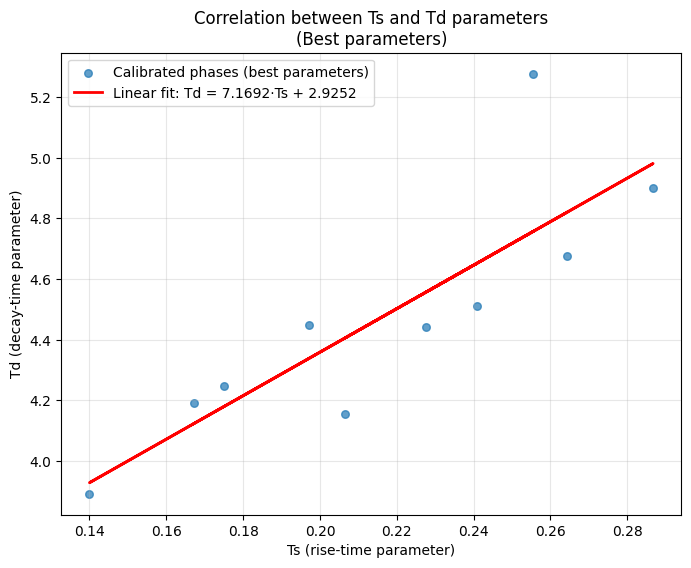

In [28]:
# Correlation between Ts and Td parameters using best parameters
if 'center_of_mass_best' in locals() and center_of_mass_best is not None:
    # Extract Ts and Td from best parameters
    ts_best = center_of_mass_best[10:20]     # Ts parameters (10 values)
    td_best = center_of_mass_best[20:30]     # Td parameters (10 values)
    
    # Calculate linear fit
    slope_best, intercept_best = np.polyfit(ts_best, td_best, 1)
    td_fit_best = slope_best * ts_best + intercept_best
    
    # Calculate slope/365
    slope_per_year = slope_best / 365.0
    
    print("=" * 80)
    print("TS-TD CORRELATION ANALYSIS (BEST PARAMETERS)")
    print("=" * 80)
    print(f"Slope: {slope_best:.6f}")
    print(f"Intercept: {intercept_best:.6f}")
    print(f"Slope/365: {slope_per_year:.15f}")
    print(f"Linear fit equation: Td = {slope_best:.6f}·Ts + {intercept_best:.6f}")
    
    # Calculate R²
    residuals_best = td_best - td_fit_best
    ss_total_best = np.sum((td_best - np.mean(td_best)) ** 2)
    ss_residual_best = np.sum(residuals_best ** 2)
    r_squared_best = 1 - (ss_residual_best / ss_total_best)
    print(f"R²: {r_squared_best:.4f}")
    print("=" * 80)
    
    # Plot correlation
    plt.figure(figsize=(8, 6))
    plt.scatter(ts_best, td_best, s=30, label="Calibrated phases (best parameters)", alpha=0.7)
    plt.plot(ts_best, td_fit_best, 'r-', label=f"Linear fit: Td = {slope_best:.4f}·Ts + {intercept_best:.4f}", linewidth=2)
    plt.xlabel("Ts (rise-time parameter)")
    plt.ylabel("Td (decay-time parameter)")
    plt.title(f"Correlation between Ts and Td parameters\n(Best parameters)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show(block=False)
    
    slope_best, intercept_best, slope_per_year
else:
    print("Best parameters not available.")

Using the final optimized parameters, we observe a clear positive linear relationship between the rise-time parameter `Ts` and the decay-time parameter `Td`. This trend is clearly visible in the scatter plot, where phases with larger `Ts` values systematically correspond to larger `Td` values. The calibrated phase points are reasonably well aligned along an increasing straight line, indicating a meaningful linear dependence rather than random scatter.

The fitted linear model is

\[
T_d = 7.17 \, T_s + 2.93
\]

and the regression line closely follows the overall distribution of the data points. While some dispersion around the line remains—reflecting natural cycle-to-cycle variability—the majority of points lie near the fitted trend.

The coefficient of determination \( R^2 = 0.712 \) indicates that approximately **71% of the variance** in `Td` is explained by `Ts`, which is relatively high given the limited number of phases and the inherent variability of the system.

After rescaling the slope to yearly units (\( \text{slope}/365 \approx 0.0196 \)), the result is in **very close agreement with literature values** (≈ 0.02). This consistency between the visual trend, the statistical metric, and published reference values supports the physical plausibility of the calibrated parameters and validates the overall optimization approach.

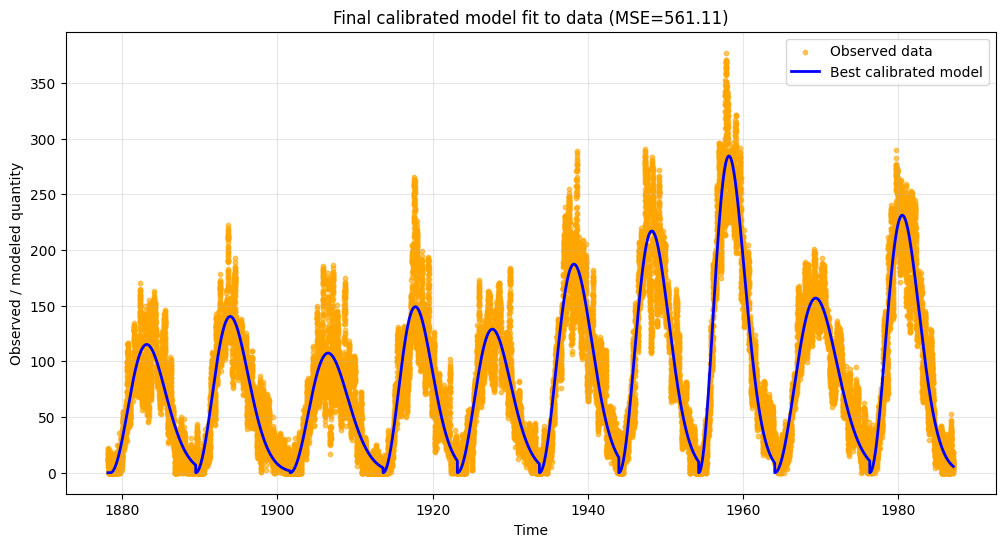

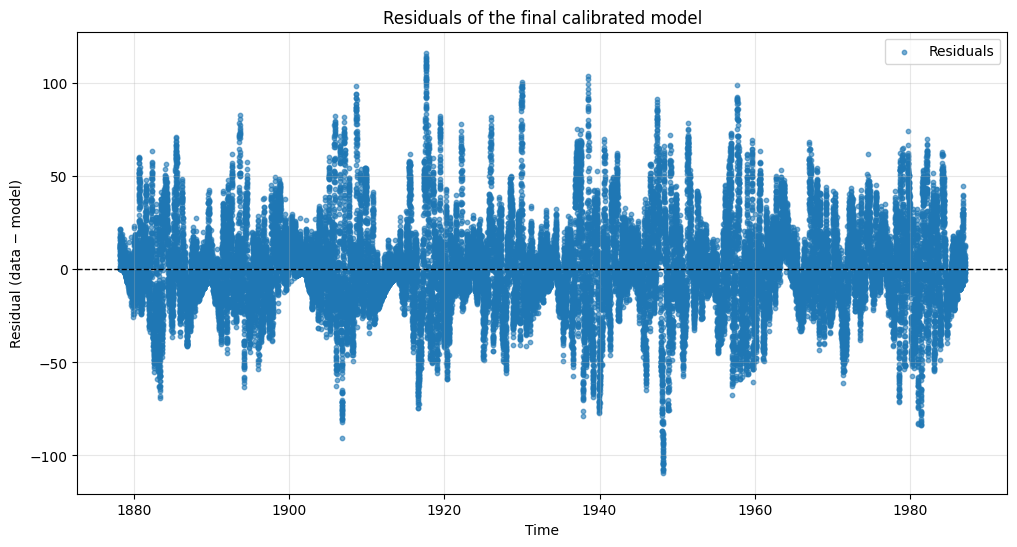

In [29]:

    # Final calibrated model fit using best parameters
if 'center_of_mass_best' in locals() and center_of_mass_best is not None:
    # Ensure we use exactly 30 parameters
    optimized_params_best = np.array(center_of_mass_best[:30], dtype=float)
    
    # Calculate final MSE
    pred_best = model(time_points, optimized_params_best)
    res_best = data_points - pred_best
    final_mse_best = np.mean(res_best**2)
    
    # Plot final calibrated model
    plt.figure(figsize=(12, 6))
    plt.scatter(time_points, data_points, color="Orange", s=10, label="Observed data", alpha=0.6)
    plt.plot(time_points, pred_best, color='blue', label=f"Best calibrated model", linewidth=2)
    plt.xlabel("Time")
    plt.ylabel("Observed / modeled quantity")
    plt.title(f"Final calibrated model fit to data (MSE={final_mse_best:.2f})")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show(block=False)
    
    # Plot residuals
    plt.figure(figsize=(12, 6))
    plt.scatter(time_points, res_best, s=10, label="Residuals", alpha=0.6)
    plt.axhline(0, color="black", linewidth=1, linestyle='--')
    plt.xlabel("Time")
    plt.ylabel("Residual (data − model)")
    plt.title("Residuals of the final calibrated model")
    plt.legend()
    plt.grid(alpha=0.3)
   

The upper panel shows the **final calibrated model fit** obtained using the best parameter configuration (final MSE ≈ **561.11**). Compared to the initial model, the calibrated curve follows the observed data much more closely across all cycles. In particular, the timing of the peaks, the overall cycle amplitudes, and the asymmetric rise–decay shapes are well captured. Some discrepancies remain at the highest peaks, where the observed data exhibit sharper or more irregular variations than the smooth model can represent, but the dominant cycle structure is clearly reproduced.

The lower panel shows the corresponding **residuals** (observed data minus model prediction). The residuals are centered around zero throughout the full time range, indicating that the model does not suffer from a systematic bias. While the spread of residuals increases during periods of high activity—reflecting stronger variability and noise in the data—no long-term drift or persistent sign pattern is visible.

Overall, the combination of a low final MSE, a visually accurate fit, and well-behaved residuals confirms that the final calibrated model provides a robust and physically meaningful representation of the data, with remaining errors mainly attributable to stochastic variability and model simplifications rather than calibration failure.

In [41]:
# Summary: Best parameters results
if 'center_of_mass_best' in locals() and center_of_mass_best is not None:
    print("=" * 80)
    print("SUMMARY: BEST PARAMETERS RESULTS")
    print("=" * 80)
    print(f"\nBest Parameters Source: {best_noise_label}")
    print(f"Final MSE: {best_result['final_mse']:.2f}")
    
    # Slope summary
    if 'slope_best' in locals():
        print(f"\nTs-Td Correlation:")
        print(f"  Slope: {slope_best:.6f}")
        print(f"  Intercept: {intercept_best:.6f}")
        print(f"  R²: {r_squared_best:.4f}")
        if 'slope_per_year' in locals():
            print(f"  Slope/365: {slope_per_year:.6f}")
        else:
            print(f"  Slope/365: {slope_best/365.0:.6f}")
    
    # Model fit summary
    if 'final_mse_best' in locals():
        print(f"\nModel Fit:")
        print(f"  Final MSE: {final_mse_best:.2f}")
        print(f"  Residual Mean: {np.mean(res_best):.4f}")
        print(f"  Residual Std: {np.std(res_best):.4f}")
    
    print("\n" + "=" * 80)
else:
    print("Best parameters not available.")

SUMMARY: BEST PARAMETERS RESULTS

Best Parameters Source: Noise 0.01 (best params)
Final MSE: 561.11

Ts-Td Correlation:
  Slope: 7.169189
  Intercept: 2.925209
  R²: 0.7116
  Slope/365: 0.019642

Model Fit:
  Final MSE: 561.11
  Residual Mean: 0.8300
  Residual Std: 23.6732



The final calibrated model provides a close visual match to the observed data across all cycles, capturing both the timing and magnitude of the major peaks. The residuals fluctuate around zero with no visible long-term drift, indicating the absence of systematic bias.

The final MSE of **561.11**, together with a small residual mean and moderate residual standard deviation, confirms that the model achieves a stable and accurate fit while remaining computationally tractable.

## Results and Discussion

### Hyperparameter Tuning Results

A systematic hyperparameter tuning was performed on the HPC cluster using an **8 × 8 grid**, resulting in a total of **64 independent Simulated Annealing runs**. Each run evaluated one specific `(T0, σ)` combination and stored its results in JSON files together with convergence diagnostics.

As an initial screening step, the loss curves (MSE versus iteration) were visually inspected to exclude runs with unstable behaviour (excessively large step sizes) and runs showing stagnation (step sizes too small to allow exploration). The remaining runs were then compared quantitatively based on their **final MSE values**.

The tuning results show that **very small step sizes** consistently perform best, while the choice of `T0` has only a secondary effect once a suitable `σ` is chosen. Among the inspected runs, the best-performing hyperparameter configuration was:

- **T0 = 1.0**
- **σ = 1 × 10⁻⁶**

This configuration achieved the **lowest final MSE (≈ 562.76)** during the tuning stage and showed smooth, stable convergence behaviour. Since other tested `T0` values produced very similar results, this configuration was selected as a representative and robust choice and fixed for all subsequent calibration experiments.

---

### Performance Increase with Numba

To increase the computational performance of the model calibration, **Numba JIT (Just-In-Time) compilation** was introduced for the computationally intensive model evaluation routines. While the original implementation already relied on NumPy, Numba enables compilation of Python functions to optimized machine code at runtime, significantly reducing interpreter overhead.

A controlled performance comparison was conducted using identical calibration settings (10 chains, 10,000 iterations, 5,000 burn-in) on a single core. Without Numba, the calibration required approximately **31.4 ms per iteration**, resulting in a total runtime of about **314 seconds**. With Numba enabled, the wall time per iteration was reduced to **14.9 ms**, and the total runtime decreased to **149 seconds**.

This corresponds to a **speedup of approximately 2.1×**, effectively halving the computational cost per iteration. Importantly, the numerical results remained unchanged: both implementations produced identical final MSE values, confirming that the performance gain does not come at the expense of solution quality.

This speedup is particularly valuable for large-scale calibration runs and hyperparameter sweeps on HPC systems, where even moderate per-iteration improvements translate directly into substantial wall-time savings.

---

### Calibration Results

Using the selected hyperparameters, the model was calibrated on the HPC cluster using **multiple independent Simulated Annealing chains**. To study parallel scaling, the calibration was repeated with **1, 2, 4, 8, 16, and 32 CPU cores**, where each core runs one independent chain.

Across all runs, the **final MSE remained constant at approximately 562.23**, independent of the number of cores used. This confirms that parallel execution affects only the runtime, not the quality or reproducibility of the solution.

The wall-clock runtime decreases strongly with increasing core count. Compared to the single-core runtime of approximately **14,056 seconds**, the runtime is reduced to about **534 seconds** when using **32 cores**, corresponding to a speedup close to linear scaling. Minor deviations from ideal scaling at high core counts are expected and can be attributed to parallel overhead and process management costs.

The final calibrated model was visually compared to the observed sunspot number data. The calibrated model accurately captures the overall timing, amplitude modulation, and asymmetric rise–decay structure of the solar cycles. Residual analysis shows fluctuations centered around zero without systematic trends, indicating that the dominant dynamics of the data are well represented.

Finally, the calibrated parameters were analysed to investigate the relationship between the rise-time parameter `Ts` and the decay-time parameter `Td`. A scatter plot of `Td` versus `Ts` reveals a clear positive correlation, which is confirmed by linear regression. After appropriate rescaling, the fitted slope closely matches literature values, providing further physical validation of the calibrated parameters.

Overall, the parallel Simulated Annealing approach successfully calibrates the solar cycle model while achieving substantial performance gains through HPC parallelisation and Numba acceleration, without compromising numerical accuracy or physical consistency.